In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""
test=""
z_diff=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "uber"
z_range = "all_z"
key = ""
quantile = ""
test = "foreground"
z_diff = 0.01


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
z_diff=float(z_diff)

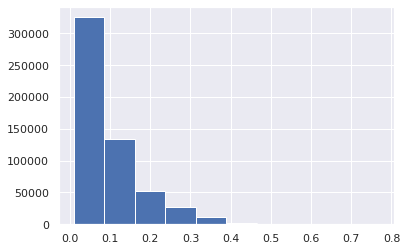

In [5]:
if test=="foreground":
    members=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])>=z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
    
elif test=="background":
    members=background=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])<=-z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
elif test=="":
    members=shapes
else:
    raise TypeError

In [6]:
if vol!="uber":
    members=shapes

In [7]:
if quantile!="":
    i=int(quantile)

In [8]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [9]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [10]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [11]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [12]:
NBINS=10

In [13]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [14]:
len(shapes)

1079244

In [15]:
len(members)

552840

In [16]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [17]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [18]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [19]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [20]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

3it [00:00, 29.10it/s]

10it [00:00, 34.99it/s]

18it [00:00, 41.63it/s]

26it [00:00, 47.41it/s]

34it [00:00, 52.91it/s]

42it [00:00, 58.47it/s]

50it [00:00, 62.98it/s]

58it [00:00, 65.91it/s]

65it [00:00, 63.59it/s]

72it [00:01, 64.94it/s]

80it [00:01, 68.21it/s]

88it [00:01, 70.80it/s]

96it [00:01, 73.26it/s]

104it [00:01, 74.74it/s]

112it [00:01, 75.98it/s]

120it [00:01, 76.65it/s]

128it [00:01, 73.78it/s]

136it [00:01, 71.43it/s]

144it [00:02, 66.98it/s]

152it [00:02, 68.29it/s]

160it [00:02, 70.79it/s]

168it [00:02, 72.49it/s]

176it [00:02, 71.93it/s]

184it [00:02, 72.79it/s]

192it [00:02, 74.38it/s]

200it [00:02, 75.06it/s]

208it [00:02, 75.57it/s]

216it [00:03, 73.96it/s]

224it [00:03, 74.97it/s]

232it [00:03, 75.39it/s]

240it [00:03, 76.30it/s]

248it [00:03, 75.96it/s]

256it [00:03, 76.66it/s]

264it [00:03, 77.44it/s]

272it [00:03, 77.43it/s]

280it [00:03, 75.24it/s]

288it [00:03, 75.78it/s]

296it [00:04, 73.80it/s]

304it [00:04, 74.67it/s]

312it [00:04, 75.73it/s]

320it [00:04, 75.87it/s]

328it [00:04, 75.76it/s]

336it [00:04, 75.77it/s]

344it [00:04, 73.51it/s]

352it [00:04, 69.66it/s]

360it [00:04, 71.82it/s]

368it [00:05, 73.17it/s]

376it [00:05, 73.88it/s]

384it [00:05, 63.79it/s]

391it [00:05, 57.94it/s]

398it [00:05, 58.21it/s]

405it [00:05, 60.50it/s]

413it [00:05, 63.12it/s]

421it [00:05, 65.42it/s]

428it [00:06, 59.07it/s]

435it [00:06, 59.94it/s]

442it [00:06, 60.66it/s]

449it [00:06, 63.11it/s]

456it [00:06, 62.52it/s]

463it [00:06, 62.64it/s]

470it [00:06, 62.53it/s]

477it [00:06, 62.28it/s]

484it [00:06, 61.89it/s]

491it [00:07, 61.55it/s]

498it [00:07, 57.31it/s]

506it [00:07, 62.19it/s]

514it [00:07, 66.05it/s]

522it [00:07, 69.48it/s]

531it [00:07, 72.55it/s]

539it [00:07, 71.92it/s]

547it [00:07, 71.84it/s]

555it [00:07, 74.09it/s]

563it [00:08, 75.71it/s]

572it [00:08, 76.89it/s]

580it [00:08, 77.34it/s]

588it [00:08, 77.81it/s]

596it [00:08, 77.74it/s]

604it [00:08, 78.09it/s]

612it [00:08, 78.45it/s]

620it [00:08, 78.56it/s]

628it [00:08, 78.76it/s]

637it [00:09, 79.26it/s]

645it [00:09, 79.33it/s]

653it [00:09, 76.56it/s]

661it [00:09, 76.99it/s]

669it [00:09, 68.62it/s]

677it [00:09, 66.62it/s]

684it [00:09, 67.45it/s]

692it [00:09, 70.63it/s]

701it [00:09, 73.35it/s]

709it [00:10, 74.71it/s]

717it [00:10, 75.46it/s]

725it [00:10, 76.16it/s]

733it [00:10, 76.36it/s]

742it [00:10, 77.32it/s]

750it [00:10, 68.67it/s]

758it [00:10, 65.71it/s]

765it [00:10, 63.73it/s]

772it [00:10, 62.24it/s]

779it [00:11, 61.18it/s]

787it [00:11, 64.71it/s]

795it [00:11, 67.75it/s]

803it [00:11, 69.74it/s]

811it [00:11, 71.35it/s]

819it [00:11, 72.68it/s]

827it [00:11, 73.97it/s]

835it [00:11, 74.50it/s]

843it [00:11, 74.63it/s]

851it [00:12, 72.68it/s]

859it [00:12, 72.48it/s]

867it [00:12, 74.35it/s]

875it [00:12, 67.21it/s]

882it [00:12, 67.81it/s]

890it [00:12, 69.77it/s]

898it [00:12, 71.34it/s]

906it [00:12, 73.20it/s]

914it [00:12, 74.17it/s]

922it [00:13, 74.63it/s]

930it [00:13, 74.91it/s]

938it [00:13, 74.85it/s]

946it [00:13, 69.71it/s]

954it [00:13, 71.58it/s]

962it [00:13, 73.38it/s]

970it [00:13, 74.64it/s]

978it [00:13, 66.73it/s]

986it [00:13, 68.99it/s]

994it [00:14, 65.23it/s]

1001it [00:14, 63.33it/s]

1009it [00:14, 64.15it/s]

1017it [00:14, 66.81it/s]

1025it [00:14, 69.23it/s]

1033it [00:14, 71.02it/s]

1041it [00:14, 72.06it/s]

1049it [00:14, 72.40it/s]

1057it [00:14, 73.26it/s]

1065it [00:15, 74.21it/s]

1073it [00:15, 75.02it/s]

1081it [00:15, 75.13it/s]

1089it [00:15, 75.61it/s]

1097it [00:15, 75.60it/s]

1105it [00:15, 75.91it/s]

1113it [00:15, 76.33it/s]

1121it [00:15, 76.05it/s]

1129it [00:15, 75.91it/s]

1137it [00:16, 73.99it/s]

1145it [00:16, 67.86it/s]

1152it [00:16, 64.15it/s]

1159it [00:16, 62.67it/s]

1166it [00:16, 61.68it/s]

1174it [00:16, 65.84it/s]

1182it [00:16, 69.20it/s]

1190it [00:16, 71.93it/s]

1198it [00:16, 73.31it/s]

1206it [00:17, 74.71it/s]

1214it [00:17, 75.74it/s]

1222it [00:17, 74.30it/s]

1230it [00:17, 75.35it/s]

1238it [00:17, 75.93it/s]

1246it [00:17, 76.86it/s]

1254it [00:17, 77.28it/s]

1262it [00:17, 77.43it/s]

1270it [00:17, 77.59it/s]

1278it [00:17, 77.62it/s]

1286it [00:18, 77.43it/s]

1294it [00:18, 77.43it/s]

1302it [00:18, 77.27it/s]

1310it [00:18, 77.36it/s]

1318it [00:18, 75.34it/s]

1326it [00:18, 73.47it/s]

1334it [00:18, 74.93it/s]

1342it [00:18, 76.26it/s]

1350it [00:18, 77.07it/s]

1358it [00:18, 77.86it/s]

1366it [00:19, 78.20it/s]

1374it [00:19, 78.32it/s]

1382it [00:19, 72.78it/s]

1390it [00:19, 74.53it/s]

1399it [00:19, 76.08it/s]

1407it [00:19, 77.15it/s]

1416it [00:19, 78.37it/s]

1424it [00:19, 76.60it/s]

1432it [00:20, 69.46it/s]

1440it [00:20, 66.95it/s]

1448it [00:20, 68.71it/s]

1456it [00:20, 70.61it/s]

1464it [00:20, 72.51it/s]

1472it [00:20, 73.64it/s]

1480it [00:20, 74.73it/s]

1488it [00:20, 76.20it/s]

1496it [00:20, 76.57it/s]

1504it [00:20, 76.47it/s]

1512it [00:21, 76.69it/s]

1520it [00:21, 76.75it/s]

1528it [00:21, 76.79it/s]

1536it [00:21, 76.71it/s]

1544it [00:21, 76.54it/s]

1552it [00:21, 76.25it/s]

1560it [00:21, 74.20it/s]

1568it [00:21, 71.89it/s]

1576it [00:21, 69.43it/s]

1583it [00:22, 59.22it/s]

1590it [00:22, 58.21it/s]

1597it [00:22, 53.85it/s]

1603it [00:22, 50.86it/s]

1610it [00:22, 53.62it/s]

1616it [00:22, 54.84it/s]

1624it [00:22, 58.87it/s]

1632it [00:22, 63.47it/s]

1640it [00:23, 66.81it/s]

1647it [00:23, 65.14it/s]

1655it [00:23, 68.73it/s]

1663it [00:23, 71.26it/s]

1671it [00:23, 71.12it/s]

1679it [00:23, 73.10it/s]

1687it [00:23, 71.84it/s]

1695it [00:23, 71.79it/s]

1703it [00:23, 72.98it/s]

1711it [00:24, 73.78it/s]

1719it [00:24, 73.30it/s]

1727it [00:24, 73.10it/s]

1735it [00:24, 73.27it/s]

1743it [00:24, 73.63it/s]

1751it [00:24, 73.34it/s]

1759it [00:24, 73.77it/s]

1767it [00:24, 73.38it/s]

1775it [00:24, 72.15it/s]

1783it [00:25, 67.66it/s]

1791it [00:25, 70.60it/s]

1799it [00:25, 72.37it/s]

1807it [00:25, 73.64it/s]

1815it [00:25, 74.40it/s]

1823it [00:25, 75.12it/s]

1831it [00:25, 75.89it/s]

1839it [00:25, 76.09it/s]

1847it [00:25, 75.96it/s]

1855it [00:25, 76.74it/s]

1863it [00:26, 77.28it/s]

1871it [00:26, 77.37it/s]

1879it [00:26, 77.23it/s]

1887it [00:26, 77.52it/s]

1895it [00:26, 77.75it/s]

1903it [00:26, 77.94it/s]

1911it [00:26, 67.85it/s]

1919it [00:26, 64.51it/s]

1926it [00:27, 63.45it/s]

1934it [00:27, 66.85it/s]

1942it [00:27, 69.75it/s]

1950it [00:27, 72.02it/s]

1958it [00:27, 73.83it/s]

1966it [00:27, 74.10it/s]

1974it [00:27, 74.29it/s]

1982it [00:27, 75.13it/s]

1990it [00:27, 73.05it/s]

1998it [00:27, 71.98it/s]

2006it [00:28, 71.93it/s]

2014it [00:28, 73.86it/s]

2022it [00:28, 75.57it/s]

2030it [00:28, 76.80it/s]

2038it [00:28, 77.72it/s]

2046it [00:28, 78.12it/s]

2054it [00:28, 78.47it/s]

2062it [00:28, 78.11it/s]

2070it [00:28, 78.09it/s]

2078it [00:28, 76.10it/s]

2086it [00:29, 71.62it/s]

2094it [00:29, 66.96it/s]

2101it [00:29, 62.32it/s]

2109it [00:29, 65.37it/s]

2117it [00:29, 68.44it/s]

2125it [00:29, 70.82it/s]

2133it [00:29, 72.16it/s]

2141it [00:29, 73.19it/s]

2149it [00:30, 73.92it/s]

2157it [00:30, 73.19it/s]

2165it [00:30, 74.97it/s]

2173it [00:30, 76.38it/s]

2181it [00:30, 76.71it/s]

2189it [00:30, 76.95it/s]

2197it [00:30, 77.39it/s]

2205it [00:30, 77.31it/s]

2213it [00:30, 77.51it/s]

2221it [00:30, 77.82it/s]

2229it [00:31, 78.02it/s]

2237it [00:31, 78.22it/s]

2245it [00:31, 78.06it/s]

2253it [00:31, 77.49it/s]

2261it [00:31, 76.87it/s]

2269it [00:31, 76.22it/s]

2277it [00:31, 76.14it/s]

2285it [00:31, 76.85it/s]

2293it [00:31, 76.27it/s]

2301it [00:32, 73.27it/s]

2309it [00:32, 71.75it/s]

2317it [00:32, 73.06it/s]

2325it [00:32, 74.28it/s]

2333it [00:32, 72.83it/s]

2341it [00:32, 64.93it/s]

2348it [00:32, 59.99it/s]

2355it [00:32, 59.96it/s]

2362it [00:32, 58.85it/s]

2368it [00:33, 58.47it/s]

2376it [00:33, 63.02it/s]

2383it [00:33, 58.12it/s]

2389it [00:33, 57.73it/s]

2395it [00:33, 58.38it/s]

2402it [00:33, 58.97it/s]

2409it [00:33, 59.71it/s]

2416it [00:33, 59.72it/s]

2423it [00:34, 59.75it/s]

2430it [00:34, 61.77it/s]

2438it [00:34, 65.53it/s]

2446it [00:34, 68.75it/s]

2454it [00:34, 71.20it/s]

2462it [00:34, 72.36it/s]

2470it [00:34, 73.75it/s]

2478it [00:34, 74.88it/s]

2486it [00:34, 75.31it/s]

2494it [00:34, 75.97it/s]

2502it [00:35, 76.25it/s]

2510it [00:35, 76.48it/s]

2518it [00:35, 75.70it/s]

2526it [00:35, 75.12it/s]

2534it [00:35, 73.85it/s]

2542it [00:35, 75.14it/s]

2550it [00:35, 75.62it/s]

2558it [00:35, 75.66it/s]

2566it [00:35, 75.61it/s]

2574it [00:36, 73.56it/s]

2582it [00:36, 74.04it/s]

2590it [00:36, 74.02it/s]

2598it [00:36, 75.36it/s]

2606it [00:36, 76.13it/s]

2614it [00:36, 74.74it/s]

2622it [00:36, 75.16it/s]

2630it [00:36, 76.11it/s]

2638it [00:36, 76.33it/s]

2646it [00:36, 76.11it/s]

2654it [00:37, 75.87it/s]

2662it [00:37, 76.70it/s]

2670it [00:37, 73.64it/s]

2678it [00:37, 73.93it/s]

2686it [00:37, 74.53it/s]

2694it [00:37, 74.66it/s]

2702it [00:37, 75.04it/s]

2710it [00:37, 75.29it/s]

2718it [00:37, 75.83it/s]

2726it [00:38, 76.17it/s]

2734it [00:38, 76.90it/s]

2742it [00:38, 77.09it/s]

2750it [00:38, 77.34it/s]

2758it [00:38, 77.06it/s]

2766it [00:38, 74.15it/s]

2774it [00:38, 75.19it/s]

2782it [00:38, 73.46it/s]

2790it [00:38, 74.94it/s]

2798it [00:38, 75.86it/s]

2806it [00:39, 76.25it/s]

2814it [00:39, 71.65it/s]

2822it [00:39, 70.74it/s]

2830it [00:39, 72.97it/s]

2838it [00:39, 74.28it/s]

2847it [00:39, 76.12it/s]

2855it [00:39, 76.58it/s]

2863it [00:39, 77.30it/s]

2872it [00:39, 78.01it/s]

2880it [00:40, 78.30it/s]

2888it [00:40, 68.32it/s]

2896it [00:40, 62.78it/s]

2903it [00:40, 62.42it/s]

2910it [00:40, 63.11it/s]

2918it [00:40, 66.87it/s]

2926it [00:40, 69.39it/s]

2934it [00:40, 71.25it/s]

2942it [00:41, 70.24it/s]

2950it [00:41, 66.12it/s]

2957it [00:41, 63.80it/s]

2964it [00:41, 65.15it/s]

2971it [00:41, 63.25it/s]

2978it [00:41, 60.18it/s]

2985it [00:41, 60.43it/s]

2993it [00:41, 65.01it/s]

3001it [00:41, 68.87it/s]

3009it [00:42, 71.34it/s]

3017it [00:42, 73.22it/s]

3025it [00:42, 74.61it/s]

3033it [00:42, 75.08it/s]

3041it [00:42, 75.53it/s]

3049it [00:42, 74.15it/s]

3057it [00:42, 74.93it/s]

3065it [00:42, 75.86it/s]

3073it [00:42, 76.46it/s]

3081it [00:42, 76.20it/s]

3089it [00:43, 76.42it/s]

3097it [00:43, 75.95it/s]

3105it [00:43, 75.76it/s]

3113it [00:43, 76.90it/s]

3121it [00:43, 76.74it/s]

3129it [00:43, 77.60it/s]

3137it [00:43, 77.89it/s]

3146it [00:43, 78.56it/s]

3154it [00:43, 75.18it/s]

3162it [00:44, 76.00it/s]

3170it [00:44, 76.74it/s]

3179it [00:44, 77.43it/s]

3187it [00:44, 77.68it/s]

3195it [00:44, 77.56it/s]

3203it [00:44, 77.47it/s]

3211it [00:44, 77.51it/s]

3219it [00:44, 76.97it/s]

3227it [00:44, 77.34it/s]

3235it [00:44, 77.31it/s]

3243it [00:45, 77.53it/s]

3251it [00:45, 77.54it/s]

3259it [00:45, 75.57it/s]

3267it [00:45, 76.42it/s]

3275it [00:45, 74.85it/s]

3283it [00:45, 69.76it/s]

3291it [00:45, 71.86it/s]

3299it [00:45, 73.11it/s]

3307it [00:45, 74.20it/s]

3315it [00:46, 75.03it/s]

3323it [00:46, 75.49it/s]

3331it [00:46, 76.41it/s]

3339it [00:46, 73.78it/s]

3347it [00:46, 72.24it/s]

3355it [00:46, 73.84it/s]

3363it [00:46, 75.03it/s]

3371it [00:46, 75.48it/s]

3379it [00:46, 76.36it/s]

3387it [00:47, 76.57it/s]

3395it [00:47, 76.83it/s]

3403it [00:47, 76.94it/s]

3411it [00:47, 77.00it/s]

3419it [00:47, 74.63it/s]

3427it [00:47, 75.63it/s]

3435it [00:47, 74.59it/s]

3443it [00:47, 67.69it/s]

3450it [00:47, 64.66it/s]

3457it [00:48, 62.37it/s]

3464it [00:48, 56.29it/s]

3471it [00:48, 57.08it/s]

3478it [00:48, 60.06it/s]

3486it [00:48, 64.77it/s]

3494it [00:48, 67.94it/s]

3502it [00:48, 71.02it/s]

3510it [00:48, 72.52it/s]

3518it [00:48, 74.41it/s]

3526it [00:49, 75.52it/s]

3534it [00:49, 76.04it/s]

3542it [00:49, 76.50it/s]

3550it [00:49, 76.34it/s]

3558it [00:49, 76.99it/s]

3566it [00:49, 77.32it/s]

3574it [00:49, 77.01it/s]

3582it [00:49, 77.50it/s]

3590it [00:49, 78.16it/s]

3599it [00:49, 78.34it/s]

3607it [00:50, 78.15it/s]

3615it [00:50, 78.31it/s]

3623it [00:50, 78.53it/s]

3631it [00:50, 77.29it/s]

3639it [00:50, 74.62it/s]

3647it [00:50, 69.18it/s]

3655it [00:50, 66.27it/s]

3662it [00:50, 64.60it/s]

3669it [00:50, 64.77it/s]

3677it [00:51, 68.04it/s]

3684it [00:51, 66.29it/s]

3692it [00:51, 69.36it/s]

3700it [00:51, 69.74it/s]

3708it [00:51, 70.10it/s]

3716it [00:51, 72.29it/s]

3724it [00:51, 72.98it/s]

3732it [00:51, 69.00it/s]

3739it [00:51, 68.78it/s]

3746it [00:52, 64.84it/s]

3753it [00:52, 62.24it/s]

3760it [00:52, 61.75it/s]

3767it [00:52, 61.17it/s]

3774it [00:52, 59.39it/s]

3781it [00:52, 59.59it/s]

3788it [00:52, 61.17it/s]

3796it [00:52, 65.25it/s]

3804it [00:53, 68.54it/s]

3812it [00:53, 69.18it/s]

3820it [00:53, 71.10it/s]

3828it [00:53, 73.37it/s]

3836it [00:53, 74.60it/s]

3844it [00:53, 75.79it/s]

3852it [00:53, 76.32it/s]

3860it [00:53, 76.36it/s]

3868it [00:53, 74.38it/s]

3876it [00:53, 75.50it/s]

3884it [00:54, 76.30it/s]

3893it [00:54, 77.56it/s]

3901it [00:54, 77.78it/s]

3909it [00:54, 77.08it/s]

3917it [00:54, 77.04it/s]

3925it [00:54, 76.61it/s]

3933it [00:54, 69.46it/s]

3941it [00:54, 65.20it/s]

3948it [00:55, 59.27it/s]

3955it [00:55, 57.90it/s]

3961it [00:55, 56.53it/s]

3967it [00:55, 56.43it/s]

3973it [00:55, 56.41it/s]

3980it [00:55, 57.36it/s]

3986it [00:55, 56.51it/s]

3992it [00:55, 54.61it/s]

4000it [00:55, 59.24it/s]

4008it [00:56, 62.89it/s]

4016it [00:56, 65.53it/s]

4024it [00:56, 67.71it/s]

4032it [00:56, 69.49it/s]

4040it [00:56, 70.68it/s]

4048it [00:56, 72.00it/s]

4056it [00:56, 73.18it/s]

4064it [00:56, 73.40it/s]

4072it [00:56, 73.41it/s]

4080it [00:56, 73.90it/s]

4088it [00:57, 74.40it/s]

4096it [00:57, 74.24it/s]

4104it [00:57, 74.86it/s]

4112it [00:57, 74.72it/s]

4120it [00:57, 75.19it/s]

4128it [00:57, 75.33it/s]

4136it [00:57, 75.30it/s]

4144it [00:57, 76.00it/s]

4152it [00:57, 75.76it/s]

4160it [00:58, 75.66it/s]

4168it [00:58, 75.67it/s]

4176it [00:58, 76.26it/s]

4184it [00:58, 76.34it/s]

4192it [00:58, 76.29it/s]

4200it [00:58, 76.04it/s]

4208it [00:58, 75.72it/s]

4216it [00:58, 76.02it/s]

4224it [00:58, 75.67it/s]

4232it [00:58, 75.57it/s]

4240it [00:59, 75.59it/s]

4248it [00:59, 75.87it/s]

4256it [00:59, 75.65it/s]

4264it [00:59, 75.51it/s]

4272it [00:59, 74.92it/s]

4280it [00:59, 75.02it/s]

4288it [00:59, 75.32it/s]

4296it [00:59, 75.89it/s]

4304it [01:00, 56.86it/s]

4312it [01:00, 62.08it/s]

4320it [01:00, 66.06it/s]

4328it [01:00, 69.21it/s]

4336it [01:00, 71.30it/s]

4344it [01:00, 72.77it/s]

4352it [01:00, 74.11it/s]

4360it [01:00, 74.69it/s]

4368it [01:00, 75.58it/s]

4376it [01:00, 76.21it/s]

4384it [01:01, 75.64it/s]

4392it [01:01, 75.45it/s]

4400it [01:01, 68.36it/s]

4407it [01:01, 63.33it/s]

4415it [01:01, 66.48it/s]

4423it [01:01, 68.96it/s]

4431it [01:01, 70.90it/s]

4439it [01:01, 71.85it/s]

4447it [01:02, 72.97it/s]

4455it [01:02, 73.64it/s]

4463it [01:02, 73.95it/s]

4471it [01:02, 74.54it/s]

4479it [01:02, 74.77it/s]

4487it [01:02, 75.40it/s]

4495it [01:02, 73.12it/s]

4503it [01:02, 69.98it/s]

4511it [01:02, 70.84it/s]

4519it [01:03, 69.80it/s]

4527it [01:03, 66.79it/s]

4534it [01:03, 60.87it/s]

4541it [01:03, 60.07it/s]

4548it [01:03, 60.60it/s]

4555it [01:03, 60.71it/s]

4562it [01:03, 60.95it/s]

4570it [01:03, 64.66it/s]

4578it [01:03, 67.23it/s]

4586it [01:04, 69.27it/s]

4594it [01:04, 71.03it/s]

4602it [01:04, 72.70it/s]

4610it [01:04, 73.72it/s]

4618it [01:04, 73.92it/s]

4626it [01:04, 74.50it/s]

4634it [01:04, 74.51it/s]

4642it [01:04, 74.64it/s]

4650it [01:04, 75.16it/s]

4658it [01:05, 74.81it/s]

4666it [01:05, 74.55it/s]

4674it [01:05, 74.44it/s]

4682it [01:05, 74.72it/s]

4690it [01:05, 66.50it/s]

4697it [01:05, 64.83it/s]

4705it [01:05, 66.45it/s]

4713it [01:05, 69.20it/s]

4721it [01:05, 71.81it/s]

4729it [01:06, 72.87it/s]

4737it [01:06, 73.51it/s]

4745it [01:06, 71.93it/s]

4753it [01:06, 73.23it/s]

4761it [01:06, 73.24it/s]

4769it [01:06, 73.51it/s]

4777it [01:06, 74.37it/s]

4785it [01:06, 75.22it/s]

4793it [01:06, 75.75it/s]

4801it [01:07, 75.91it/s]

4809it [01:07, 75.68it/s]

4817it [01:07, 72.97it/s]

4825it [01:07, 74.01it/s]

4833it [01:07, 73.58it/s]

4841it [01:07, 69.04it/s]

4849it [01:07, 71.42it/s]

4857it [01:07, 68.92it/s]

4865it [01:07, 71.24it/s]

4873it [01:08, 67.79it/s]

4881it [01:08, 70.43it/s]

4889it [01:08, 70.37it/s]

4897it [01:08, 70.72it/s]

4905it [01:08, 72.83it/s]

4913it [01:08, 74.03it/s]

4921it [01:08, 75.36it/s]

4929it [01:08, 74.08it/s]

4937it [01:08, 72.51it/s]

4945it [01:09, 69.73it/s]

4953it [01:09, 70.15it/s]

4961it [01:09, 72.54it/s]

4969it [01:09, 74.01it/s]

4977it [01:09, 75.32it/s]

4985it [01:09, 76.02it/s]

4993it [01:09, 76.75it/s]

5001it [01:09, 76.79it/s]

5009it [01:09, 76.94it/s]

5017it [01:09, 77.29it/s]

5025it [01:10, 77.07it/s]

5033it [01:10, 76.97it/s]

5041it [01:10, 76.38it/s]

5049it [01:10, 77.16it/s]

5057it [01:10, 75.44it/s]

5065it [01:10, 76.05it/s]

5073it [01:10, 76.57it/s]

5081it [01:10, 77.01it/s]

5089it [01:10, 76.78it/s]

5097it [01:11, 75.22it/s]

5105it [01:11, 69.86it/s]

5113it [01:11, 65.37it/s]

5120it [01:11, 64.56it/s]

5127it [01:11, 63.45it/s]

5134it [01:11, 62.26it/s]

5141it [01:11, 62.33it/s]

5148it [01:11, 61.82it/s]

5155it [01:11, 61.62it/s]

5162it [01:12, 61.80it/s]

5169it [01:12, 61.71it/s]

5176it [01:12, 61.09it/s]

5183it [01:12, 61.00it/s]

5190it [01:12, 60.97it/s]

5197it [01:12, 60.61it/s]

5204it [01:12, 61.24it/s]

5211it [01:12, 61.36it/s]

5218it [01:13, 61.78it/s]

5226it [01:13, 66.07it/s]

5234it [01:13, 69.62it/s]

5242it [01:13, 72.11it/s]

5250it [01:13, 74.22it/s]

5259it [01:13, 76.14it/s]

5267it [01:13, 76.99it/s]

5275it [01:13, 77.48it/s]

5283it [01:13, 77.86it/s]

5291it [01:13, 77.79it/s]

5299it [01:14, 77.70it/s]

5307it [01:14, 77.95it/s]

5315it [01:14, 77.85it/s]

5323it [01:14, 78.14it/s]

5331it [01:14, 77.28it/s]

5339it [01:14, 77.43it/s]

5347it [01:14, 77.51it/s]

5355it [01:14, 77.08it/s]

5363it [01:14, 77.64it/s]

5371it [01:14, 77.74it/s]

5379it [01:15, 77.89it/s]

5387it [01:15, 78.24it/s]

5395it [01:15, 78.13it/s]

5403it [01:15, 78.06it/s]

5411it [01:15, 72.56it/s]

5419it [01:15, 73.50it/s]

5427it [01:15, 74.30it/s]

5435it [01:15, 75.20it/s]

5443it [01:15, 75.26it/s]

5451it [01:16, 75.95it/s]

5459it [01:16, 76.36it/s]

5467it [01:16, 75.95it/s]

5475it [01:16, 75.88it/s]

5483it [01:16, 76.16it/s]

5491it [01:16, 76.54it/s]

5499it [01:16, 76.50it/s]

5507it [01:16, 76.41it/s]

5515it [01:16, 76.55it/s]

5523it [01:16, 74.45it/s]

5531it [01:17, 72.62it/s]

5539it [01:17, 72.23it/s]

5547it [01:17, 72.57it/s]

5555it [01:17, 69.24it/s]

5562it [01:17, 66.10it/s]

5570it [01:17, 68.14it/s]

5578it [01:17, 70.38it/s]

5586it [01:17, 72.14it/s]

5594it [01:17, 73.02it/s]

5602it [01:18, 71.46it/s]

5610it [01:18, 66.54it/s]

5617it [01:18, 66.02it/s]

5625it [01:18, 68.50it/s]

5633it [01:18, 70.80it/s]

5641it [01:18, 72.59it/s]

5649it [01:18, 74.06it/s]

5657it [01:18, 75.11it/s]

5665it [01:18, 75.86it/s]

5673it [01:19, 71.81it/s]

5681it [01:19, 63.64it/s]

5688it [01:19, 61.31it/s]

5695it [01:19, 59.20it/s]

5702it [01:19, 58.92it/s]

5708it [01:19, 58.43it/s]

5714it [01:19, 57.69it/s]

5720it [01:19, 56.56it/s]

5726it [01:20, 57.04it/s]

5732it [01:20, 53.99it/s]

5740it [01:20, 58.76it/s]

5748it [01:20, 62.88it/s]

5756it [01:20, 66.60it/s]

5764it [01:20, 68.65it/s]

5772it [01:20, 70.99it/s]

5780it [01:20, 73.27it/s]

5788it [01:20, 73.73it/s]

5796it [01:21, 71.59it/s]

5804it [01:21, 67.41it/s]

5812it [01:21, 70.16it/s]

5820it [01:21, 70.82it/s]

5828it [01:21, 68.10it/s]

5836it [01:21, 70.28it/s]

5844it [01:21, 71.62it/s]

5852it [01:21, 72.88it/s]

5860it [01:21, 73.64it/s]

5868it [01:22, 73.93it/s]

5876it [01:22, 74.44it/s]

5884it [01:22, 74.86it/s]

5892it [01:22, 75.31it/s]

5900it [01:22, 75.83it/s]

5908it [01:22, 76.26it/s]

5916it [01:22, 74.79it/s]

5924it [01:22, 67.44it/s]

5932it [01:22, 70.16it/s]

5940it [01:23, 69.98it/s]

5948it [01:23, 71.61it/s]

5956it [01:23, 72.92it/s]

5964it [01:23, 73.82it/s]

5972it [01:23, 74.20it/s]

5980it [01:23, 74.73it/s]

5988it [01:23, 75.33it/s]

5996it [01:23, 75.96it/s]

6004it [01:23, 76.55it/s]

6012it [01:23, 76.95it/s]

6020it [01:24, 76.78it/s]

6028it [01:24, 67.50it/s]

6035it [01:24, 65.16it/s]

6042it [01:24, 62.97it/s]

6050it [01:24, 65.99it/s]

6058it [01:24, 69.18it/s]

6066it [01:24, 71.48it/s]

6074it [01:24, 73.15it/s]

6082it [01:25, 68.50it/s]

6090it [01:25, 71.19it/s]

6098it [01:25, 73.33it/s]

6106it [01:25, 72.61it/s]

6114it [01:25, 73.58it/s]

6122it [01:25, 74.80it/s]

6131it [01:25, 76.34it/s]

6139it [01:25, 77.03it/s]

6147it [01:25, 75.60it/s]

6155it [01:25, 76.30it/s]

6163it [01:26, 76.79it/s]

6171it [01:26, 76.30it/s]

6179it [01:26, 68.92it/s]

6187it [01:26, 66.08it/s]

6194it [01:26, 66.66it/s]

6202it [01:26, 68.91it/s]

6210it [01:26, 70.91it/s]

6218it [01:26, 72.62it/s]

6226it [01:26, 73.45it/s]

6234it [01:27, 73.95it/s]

6242it [01:27, 74.49it/s]

6250it [01:27, 74.49it/s]

6258it [01:27, 66.62it/s]

6266it [01:27, 69.08it/s]

6274it [01:27, 71.28it/s]

6282it [01:27, 73.06it/s]

6290it [01:27, 74.12it/s]

6298it [01:27, 74.79it/s]

6306it [01:28, 75.51it/s]

6314it [01:28, 75.65it/s]

6322it [01:28, 76.09it/s]

6330it [01:28, 73.75it/s]

6338it [01:28, 69.38it/s]

6346it [01:28, 66.65it/s]

6353it [01:28, 64.09it/s]

6360it [01:28, 64.63it/s]

6367it [01:28, 64.02it/s]

6374it [01:29, 63.25it/s]

6381it [01:29, 62.25it/s]

6388it [01:29, 60.05it/s]

6395it [01:29, 57.12it/s]

6402it [01:29, 60.16it/s]

6410it [01:29, 64.51it/s]

6417it [01:29, 62.04it/s]

6424it [01:29, 61.72it/s]

6431it [01:30, 59.20it/s]

6438it [01:30, 59.63it/s]

6445it [01:30, 60.88it/s]

6453it [01:30, 64.82it/s]

6461it [01:30, 68.31it/s]

6469it [01:30, 70.67it/s]

6477it [01:30, 73.15it/s]

6485it [01:30, 74.02it/s]

6493it [01:30, 74.87it/s]

6501it [01:31, 73.17it/s]

6509it [01:31, 74.83it/s]

6517it [01:31, 75.74it/s]

6525it [01:31, 76.59it/s]

6533it [01:31, 76.28it/s]

6541it [01:31, 77.22it/s]

6549it [01:31, 77.58it/s]

6557it [01:31, 76.36it/s]

6565it [01:31, 76.62it/s]

6573it [01:31, 76.65it/s]

6581it [01:32, 76.81it/s]

6589it [01:32, 76.50it/s]

6597it [01:32, 71.61it/s]

6605it [01:32, 73.15it/s]

6613it [01:32, 74.52it/s]

6621it [01:32, 75.09it/s]

6629it [01:32, 76.34it/s]

6637it [01:32, 77.11it/s]

6645it [01:32, 76.41it/s]

6653it [01:33, 76.36it/s]

6661it [01:33, 76.23it/s]

6669it [01:33, 76.51it/s]

6677it [01:33, 77.02it/s]

6685it [01:33, 76.46it/s]

6693it [01:33, 70.86it/s]

6701it [01:33, 66.53it/s]

6709it [01:33, 69.60it/s]

6717it [01:33, 71.49it/s]

6725it [01:34, 73.26it/s]

6733it [01:34, 74.56it/s]

6741it [01:34, 70.65it/s]

6749it [01:34, 72.74it/s]

6757it [01:34, 70.26it/s]

6765it [01:34, 72.29it/s]

6773it [01:34, 73.90it/s]

6781it [01:34, 75.09it/s]

6789it [01:34, 76.13it/s]

6797it [01:34, 76.65it/s]

6805it [01:35, 74.32it/s]

6813it [01:35, 65.77it/s]

6820it [01:35, 61.76it/s]

6828it [01:35, 65.26it/s]

6836it [01:35, 68.83it/s]

6844it [01:35, 71.53it/s]

6852it [01:35, 73.61it/s]

6860it [01:35, 74.68it/s]

6868it [01:35, 75.41it/s]

6876it [01:36, 68.34it/s]

6884it [01:36, 64.70it/s]

6891it [01:36, 63.56it/s]

6898it [01:36, 63.10it/s]

6906it [01:36, 66.52it/s]

6914it [01:36, 69.49it/s]

6922it [01:36, 65.58it/s]

6930it [01:36, 68.30it/s]

6938it [01:37, 70.67it/s]

6946it [01:37, 70.70it/s]

6954it [01:37, 71.71it/s]

6962it [01:37, 72.95it/s]

6970it [01:37, 73.66it/s]

6978it [01:37, 67.82it/s]

6986it [01:37, 70.45it/s]

6994it [01:37, 64.96it/s]

7002it [01:37, 67.50it/s]

7010it [01:38, 69.60it/s]

7018it [01:38, 71.64it/s]

7026it [01:38, 72.69it/s]

7034it [01:38, 73.98it/s]

7042it [01:38, 72.61it/s]

7050it [01:38, 73.68it/s]

7058it [01:38, 68.54it/s]

7065it [01:38, 65.89it/s]

7072it [01:38, 64.14it/s]

7079it [01:39, 60.98it/s]

7086it [01:39, 61.69it/s]

7094it [01:39, 64.27it/s]

7102it [01:39, 67.60it/s]

7110it [01:39, 70.60it/s]

7118it [01:39, 72.52it/s]

7126it [01:39, 74.35it/s]

7134it [01:39, 75.16it/s]

7142it [01:39, 75.88it/s]

7150it [01:40, 75.52it/s]

7158it [01:40, 70.51it/s]

7166it [01:40, 67.08it/s]

7173it [01:40, 66.28it/s]

7180it [01:40, 62.54it/s]

7188it [01:40, 66.01it/s]

7196it [01:40, 69.45it/s]

7204it [01:40, 71.66it/s]

7212it [01:40, 73.57it/s]

7220it [01:41, 75.29it/s]

7228it [01:41, 75.84it/s]

7236it [01:41, 76.66it/s]

7244it [01:41, 77.08it/s]

7252it [01:41, 77.29it/s]

7260it [01:41, 78.06it/s]

7268it [01:41, 78.41it/s]

7276it [01:41, 78.36it/s]

7284it [01:41, 78.30it/s]

7292it [01:42, 78.19it/s]

7300it [01:42, 77.70it/s]

7308it [01:42, 77.97it/s]

7316it [01:42, 78.01it/s]

7324it [01:42, 77.68it/s]

7332it [01:42, 77.92it/s]

7340it [01:42, 77.47it/s]

7349it [01:42, 78.37it/s]

7357it [01:42, 78.27it/s]

7365it [01:42, 78.11it/s]

7373it [01:43, 77.99it/s]

7381it [01:43, 77.49it/s]

7389it [01:43, 77.57it/s]

7397it [01:43, 77.97it/s]

7405it [01:43, 78.23it/s]

7413it [01:43, 78.40it/s]

7421it [01:43, 78.30it/s]

7429it [01:43, 77.84it/s]

7437it [01:43, 77.88it/s]

7445it [01:43, 77.46it/s]

7453it [01:44, 75.32it/s]

7461it [01:44, 75.77it/s]

7469it [01:44, 76.24it/s]

7477it [01:44, 72.61it/s]

7485it [01:44, 73.85it/s]

7493it [01:44, 74.72it/s]

7501it [01:44, 74.76it/s]

7509it [01:44, 75.18it/s]

7517it [01:44, 75.26it/s]

7525it [01:45, 73.29it/s]

7533it [01:45, 74.73it/s]

7541it [01:45, 75.72it/s]

7549it [01:45, 74.41it/s]

7557it [01:45, 74.35it/s]

7565it [01:45, 75.29it/s]

7573it [01:45, 75.91it/s]

7581it [01:45, 76.44it/s]

7589it [01:45, 76.03it/s]

7597it [01:46, 73.52it/s]

7605it [01:46, 68.75it/s]

7612it [01:46, 66.00it/s]

7620it [01:46, 68.98it/s]

7628it [01:46, 70.61it/s]

7636it [01:46, 72.24it/s]

7644it [01:46, 67.06it/s]

7652it [01:46, 68.66it/s]

7660it [01:46, 71.18it/s]

7668it [01:47, 72.21it/s]

7676it [01:47, 71.77it/s]

7684it [01:47, 67.15it/s]

7692it [01:47, 69.07it/s]

7700it [01:47, 70.62it/s]

7708it [01:47, 72.30it/s]

7716it [01:47, 73.64it/s]

7724it [01:47, 74.14it/s]

7732it [01:47, 74.52it/s]

7740it [01:48, 71.92it/s]

7748it [01:48, 68.50it/s]

7755it [01:48, 64.97it/s]

7763it [01:48, 67.11it/s]

7770it [01:48, 66.83it/s]

7777it [01:48, 63.24it/s]

7784it [01:48, 63.74it/s]

7791it [01:48, 60.84it/s]

7799it [01:48, 64.91it/s]

7807it [01:49, 68.26it/s]

7815it [01:49, 70.83it/s]

7823it [01:49, 72.73it/s]

7831it [01:49, 74.52it/s]

7839it [01:49, 75.03it/s]

7847it [01:49, 73.66it/s]

7855it [01:49, 73.50it/s]

7863it [01:49, 74.06it/s]

7871it [01:49, 74.94it/s]

7879it [01:50, 76.05it/s]

7887it [01:50, 76.11it/s]

7895it [01:50, 69.34it/s]

7903it [01:50, 66.32it/s]

7910it [01:50, 66.10it/s]

7918it [01:50, 69.29it/s]

7926it [01:50, 70.65it/s]

7934it [01:50, 72.36it/s]

7942it [01:50, 73.72it/s]

7950it [01:51, 74.78it/s]

7958it [01:51, 75.83it/s]

7966it [01:51, 76.29it/s]

7974it [01:51, 71.84it/s]

7982it [01:51, 73.50it/s]

7990it [01:51, 74.38it/s]

7998it [01:51, 75.07it/s]

8006it [01:51, 72.89it/s]

8014it [01:51, 71.63it/s]

8022it [01:52, 73.38it/s]

8030it [01:52, 74.58it/s]

8038it [01:52, 75.43it/s]

8046it [01:52, 75.46it/s]

8054it [01:52, 76.01it/s]

8062it [01:52, 75.29it/s]

8070it [01:52, 76.38it/s]

8078it [01:52, 77.00it/s]

8086it [01:52, 72.63it/s]

8094it [01:53, 65.93it/s]

8102it [01:53, 67.55it/s]

8110it [01:53, 69.79it/s]

8118it [01:53, 71.31it/s]

8126it [01:53, 73.63it/s]

8134it [01:53, 73.41it/s]

8142it [01:53, 75.22it/s]

8150it [01:53, 76.34it/s]

8158it [01:53, 76.93it/s]

8166it [01:53, 77.10it/s]

8174it [01:54, 77.28it/s]

8182it [01:54, 77.65it/s]

8190it [01:54, 78.03it/s]

8198it [01:54, 78.17it/s]

8206it [01:54, 76.53it/s]

8214it [01:54, 73.11it/s]

8222it [01:54, 74.26it/s]

8230it [01:54, 75.53it/s]

8238it [01:54, 75.72it/s]

8246it [01:55, 73.63it/s]

8254it [01:55, 71.77it/s]

8262it [01:55, 73.40it/s]

8270it [01:55, 74.75it/s]

8278it [01:55, 67.09it/s]

8285it [01:55, 62.22it/s]

8293it [01:55, 66.05it/s]

8301it [01:55, 69.13it/s]

8309it [01:55, 70.02it/s]

8317it [01:56, 72.17it/s]

8325it [01:56, 74.13it/s]

8333it [01:56, 75.10it/s]

8341it [01:56, 75.59it/s]

8349it [01:56, 73.59it/s]

8357it [01:56, 74.08it/s]

8365it [01:56, 75.05it/s]

8373it [01:56, 75.71it/s]

8381it [01:56, 73.63it/s]

8389it [01:57, 69.18it/s]

8396it [01:57, 66.27it/s]

8403it [01:57, 66.67it/s]

8411it [01:57, 69.37it/s]

8419it [01:57, 71.70it/s]

8427it [01:57, 72.96it/s]

8435it [01:57, 74.32it/s]

8443it [01:57, 75.05it/s]

8451it [01:57, 75.21it/s]

8459it [01:57, 75.31it/s]

8467it [01:58, 75.67it/s]

8475it [01:58, 75.60it/s]

8483it [01:58, 73.70it/s]

8491it [01:58, 73.86it/s]

8499it [01:58, 74.78it/s]

8507it [01:58, 74.91it/s]

8515it [01:58, 75.53it/s]

8523it [01:58, 75.98it/s]

8531it [01:58, 75.91it/s]

8539it [01:59, 73.83it/s]

8547it [01:59, 69.07it/s]

8554it [01:59, 65.82it/s]

8561it [01:59, 63.05it/s]

8569it [01:59, 66.69it/s]

8577it [01:59, 69.09it/s]

8585it [01:59, 71.08it/s]

8593it [01:59, 72.71it/s]

8601it [01:59, 67.55it/s]

8608it [02:00, 64.43it/s]

8615it [02:00, 62.53it/s]

8622it [02:00, 64.11it/s]

8630it [02:00, 67.00it/s]

8637it [02:00, 64.28it/s]

8644it [02:00, 62.89it/s]

8651it [02:00, 62.17it/s]

8659it [02:00, 66.22it/s]

8667it [02:00, 69.18it/s]

8675it [02:01, 71.21it/s]

8683it [02:01, 71.44it/s]

8691it [02:01, 65.65it/s]

8699it [02:01, 68.26it/s]

8707it [02:01, 70.52it/s]

8715it [02:01, 70.17it/s]

8723it [02:01, 69.09it/s]

8731it [02:01, 71.29it/s]

8739it [02:01, 73.11it/s]

8747it [02:02, 67.80it/s]

8755it [02:02, 70.77it/s]

8763it [02:02, 72.83it/s]

8771it [02:02, 73.45it/s]

8779it [02:02, 74.33it/s]

8787it [02:02, 75.04it/s]

8795it [02:02, 66.41it/s]

8803it [02:02, 69.17it/s]

8811it [02:03, 67.85it/s]

8819it [02:03, 70.18it/s]

8827it [02:03, 72.10it/s]

8835it [02:03, 74.03it/s]

8843it [02:03, 69.46it/s]

8851it [02:03, 66.66it/s]

8858it [02:03, 61.00it/s]

8865it [02:03, 61.12it/s]

8872it [02:03, 61.86it/s]

8879it [02:04, 55.15it/s]

8886it [02:04, 57.54it/s]

8894it [02:04, 62.66it/s]

8902it [02:04, 66.74it/s]

8910it [02:04, 67.45it/s]

8918it [02:04, 69.39it/s]

8926it [02:04, 71.75it/s]

8934it [02:04, 73.42it/s]

8942it [02:04, 74.91it/s]

8950it [02:05, 76.07it/s]

8958it [02:05, 76.53it/s]

8966it [02:05, 76.71it/s]

8974it [02:05, 76.81it/s]

8982it [02:05, 77.37it/s]

8990it [02:05, 77.05it/s]

8998it [02:05, 77.26it/s]

9006it [02:05, 77.10it/s]

9014it [02:05, 76.37it/s]

9022it [02:06, 76.39it/s]

9030it [02:06, 76.53it/s]

9038it [02:06, 76.54it/s]

9046it [02:06, 77.32it/s]

9054it [02:06, 73.08it/s]

9062it [02:06, 63.91it/s]

9069it [02:06, 62.10it/s]

9076it [02:06, 59.03it/s]

9083it [02:06, 59.43it/s]

9090it [02:07, 59.40it/s]

9097it [02:07, 61.62it/s]

9105it [02:07, 65.42it/s]

9113it [02:07, 68.26it/s]

9121it [02:07, 69.86it/s]

9129it [02:07, 68.56it/s]

9137it [02:07, 70.76it/s]

9145it [02:07, 66.12it/s]

9152it [02:07, 64.67it/s]

9160it [02:08, 66.53it/s]

9167it [02:08, 63.97it/s]

9175it [02:08, 65.09it/s]

9182it [02:08, 62.57it/s]

9190it [02:08, 65.14it/s]

9198it [02:08, 67.45it/s]

9206it [02:08, 69.77it/s]

9214it [02:08, 70.33it/s]

9222it [02:09, 72.01it/s]

9230it [02:09, 72.85it/s]

9238it [02:09, 73.93it/s]

9246it [02:09, 74.60it/s]

9254it [02:09, 75.26it/s]

9262it [02:09, 75.56it/s]

9270it [02:09, 75.38it/s]

9278it [02:09, 75.31it/s]

9286it [02:09, 75.69it/s]

9294it [02:09, 75.41it/s]

9302it [02:10, 75.19it/s]

9310it [02:10, 75.53it/s]

9318it [02:10, 75.46it/s]

9326it [02:10, 75.29it/s]

9334it [02:10, 74.61it/s]

9342it [02:10, 74.62it/s]

9350it [02:10, 66.58it/s]

9357it [02:10, 66.16it/s]

9365it [02:10, 67.50it/s]

9372it [02:11, 64.33it/s]

9379it [02:11, 62.44it/s]

9387it [02:11, 66.28it/s]

9395it [02:11, 68.99it/s]

9403it [02:11, 70.65it/s]

9411it [02:11, 72.59it/s]

9419it [02:11, 73.87it/s]

9427it [02:11, 74.95it/s]

9435it [02:11, 75.44it/s]

9443it [02:12, 75.29it/s]

9451it [02:12, 76.01it/s]

9459it [02:12, 76.67it/s]

9467it [02:12, 76.96it/s]

9475it [02:12, 77.11it/s]

9483it [02:12, 77.63it/s]

9491it [02:12, 77.46it/s]

9499it [02:12, 77.41it/s]

9507it [02:12, 77.54it/s]

9515it [02:12, 77.24it/s]

9523it [02:13, 77.31it/s]

9531it [02:13, 77.03it/s]

9539it [02:13, 74.66it/s]

9547it [02:13, 75.84it/s]

9555it [02:13, 76.42it/s]

9563it [02:13, 76.72it/s]

9571it [02:13, 77.20it/s]

9579it [02:13, 77.03it/s]

9587it [02:13, 69.31it/s]

9595it [02:14, 70.47it/s]

9603it [02:14, 72.61it/s]

9611it [02:14, 73.99it/s]

9619it [02:14, 74.20it/s]

9627it [02:14, 75.21it/s]

9635it [02:14, 75.02it/s]

9643it [02:14, 75.41it/s]

9651it [02:14, 69.26it/s]

9659it [02:14, 64.96it/s]

9666it [02:15, 63.40it/s]

9673it [02:15, 61.15it/s]

9681it [02:15, 65.19it/s]

9689it [02:15, 68.18it/s]

9697it [02:15, 70.71it/s]

9705it [02:15, 72.31it/s]

9713it [02:15, 73.95it/s]

9721it [02:15, 75.34it/s]

9729it [02:15, 76.13it/s]

9737it [02:16, 75.81it/s]

9745it [02:16, 76.04it/s]

9753it [02:16, 76.52it/s]

9761it [02:16, 76.44it/s]

9769it [02:16, 72.46it/s]

9777it [02:16, 73.15it/s]

9785it [02:16, 74.07it/s]

9793it [02:16, 74.19it/s]

9801it [02:16, 73.96it/s]

9809it [02:17, 72.98it/s]

9817it [02:17, 73.01it/s]

9825it [02:17, 74.11it/s]

9833it [02:17, 72.46it/s]

9841it [02:17, 67.56it/s]

9849it [02:17, 68.61it/s]

9857it [02:17, 70.79it/s]

9865it [02:17, 72.54it/s]

9873it [02:17, 73.76it/s]

9881it [02:18, 73.15it/s]

9889it [02:18, 73.77it/s]

9897it [02:18, 74.36it/s]

9905it [02:18, 73.05it/s]

9913it [02:18, 67.67it/s]

9920it [02:18, 65.27it/s]

9927it [02:18, 63.77it/s]

9935it [02:18, 66.76it/s]

9943it [02:18, 69.58it/s]

9951it [02:19, 68.37it/s]

9958it [02:19, 63.93it/s]

9965it [02:19, 59.92it/s]

9973it [02:19, 63.73it/s]

9981it [02:19, 66.78it/s]

9989it [02:19, 69.60it/s]

9997it [02:19, 71.67it/s]

10005it [02:19, 73.24it/s]

10013it [02:19, 74.20it/s]

10021it [02:20, 74.80it/s]

10029it [02:20, 75.00it/s]

10037it [02:20, 75.77it/s]

10045it [02:20, 75.90it/s]

10053it [02:20, 74.27it/s]

10061it [02:20, 71.34it/s]

10069it [02:20, 72.49it/s]

10077it [02:20, 72.90it/s]

10085it [02:20, 73.67it/s]

10093it [02:21, 74.40it/s]

10101it [02:21, 75.08it/s]

10109it [02:21, 75.25it/s]

10117it [02:21, 75.87it/s]

10125it [02:21, 76.48it/s]

10133it [02:21, 77.05it/s]

10141it [02:21, 77.03it/s]

10149it [02:21, 77.32it/s]

10157it [02:21, 74.79it/s]

10165it [02:21, 75.83it/s]

10173it [02:22, 75.68it/s]

10181it [02:22, 76.32it/s]

10189it [02:22, 77.24it/s]

10197it [02:22, 77.53it/s]

10205it [02:22, 77.98it/s]

10214it [02:22, 78.22it/s]

10222it [02:22, 78.67it/s]

10230it [02:22, 75.32it/s]

10238it [02:22, 70.16it/s]

10246it [02:23, 64.84it/s]

10254it [02:23, 68.72it/s]

10262it [02:23, 71.23it/s]

10270it [02:23, 73.47it/s]

10278it [02:23, 71.07it/s]

10286it [02:23, 73.08it/s]

10294it [02:23, 74.47it/s]

10302it [02:23, 75.84it/s]

10310it [02:23, 76.17it/s]

10318it [02:24, 74.82it/s]

10326it [02:24, 74.03it/s]

10334it [02:24, 75.25it/s]

10342it [02:24, 76.13it/s]

10350it [02:24, 75.87it/s]

10358it [02:24, 76.45it/s]

10366it [02:24, 77.13it/s]

10374it [02:24, 77.25it/s]

10382it [02:24, 77.46it/s]

10390it [02:24, 75.04it/s]

10398it [02:25, 76.00it/s]

10406it [02:25, 74.97it/s]

10414it [02:25, 72.32it/s]

10422it [02:25, 74.40it/s]

10430it [02:25, 75.58it/s]

10438it [02:25, 75.79it/s]

10447it [02:25, 77.13it/s]

10456it [02:25, 78.06it/s]

10464it [02:25, 78.54it/s]

10472it [02:26, 78.75it/s]

10480it [02:26, 78.68it/s]

10488it [02:26, 78.74it/s]

10496it [02:26, 78.20it/s]

10504it [02:26, 78.13it/s]

10512it [02:26, 78.23it/s]

10520it [02:26, 78.21it/s]

10528it [02:26, 77.68it/s]

10537it [02:26, 78.24it/s]

10545it [02:26, 78.23it/s]

10553it [02:27, 77.22it/s]

10561it [02:27, 77.65it/s]

10570it [02:27, 78.44it/s]

10578it [02:27, 78.82it/s]

10586it [02:27, 78.09it/s]

10594it [02:27, 78.15it/s]

10602it [02:27, 78.02it/s]

10610it [02:27, 70.37it/s]

10618it [02:27, 65.95it/s]

10626it [02:28, 68.68it/s]

10634it [02:28, 70.58it/s]

10642it [02:28, 55.55it/s]

10650it [02:28, 60.23it/s]

10658it [02:28, 64.87it/s]

10666it [02:28, 68.35it/s]

10674it [02:28, 67.03it/s]

10682it [02:28, 69.65it/s]

10690it [02:29, 70.25it/s]

10698it [02:29, 66.46it/s]

10705it [02:29, 65.23it/s]

10712it [02:29, 64.69it/s]

10719it [02:29, 63.92it/s]

10727it [02:29, 65.87it/s]

10734it [02:29, 66.48it/s]

10742it [02:29, 69.95it/s]

10750it [02:29, 72.53it/s]

10759it [02:30, 74.92it/s]

10768it [02:30, 76.60it/s]

10776it [02:30, 76.82it/s]

10784it [02:30, 77.33it/s]

10792it [02:30, 77.54it/s]

10800it [02:30, 77.83it/s]

10808it [02:30, 77.97it/s]

10816it [02:30, 77.46it/s]

10824it [02:30, 77.86it/s]

10832it [02:31, 61.39it/s]

10839it [02:31, 59.73it/s]

10846it [02:31, 60.73it/s]

10854it [02:31, 64.84it/s]

10861it [02:31, 62.32it/s]

10869it [02:31, 66.20it/s]

10877it [02:31, 67.53it/s]

10885it [02:31, 69.89it/s]

10893it [02:31, 71.75it/s]

10901it [02:32, 73.19it/s]

10909it [02:32, 73.27it/s]

10917it [02:32, 74.51it/s]

10925it [02:32, 75.26it/s]

10933it [02:32, 76.09it/s]

10941it [02:32, 67.14it/s]

10948it [02:32, 64.99it/s]

10955it [02:32, 63.92it/s]

10962it [02:32, 63.29it/s]

10969it [02:33, 63.84it/s]

10977it [02:33, 67.20it/s]

10985it [02:33, 69.78it/s]

10993it [02:33, 71.51it/s]

11001it [02:33, 73.03it/s]

11009it [02:33, 74.89it/s]

11017it [02:33, 75.12it/s]

11025it [02:33, 73.18it/s]

11033it [02:33, 74.61it/s]

11041it [02:34, 75.26it/s]

11049it [02:34, 76.51it/s]

11057it [02:34, 74.66it/s]

11065it [02:34, 75.60it/s]

11073it [02:34, 73.88it/s]

11081it [02:34, 67.74it/s]

11089it [02:34, 70.79it/s]

11097it [02:34, 71.74it/s]

11105it [02:34, 71.68it/s]

11113it [02:35, 73.89it/s]

11121it [02:35, 75.01it/s]

11129it [02:35, 75.65it/s]

11137it [02:35, 76.17it/s]

11145it [02:35, 76.43it/s]

11153it [02:35, 75.97it/s]

11161it [02:35, 75.97it/s]

11169it [02:35, 76.41it/s]

11177it [02:35, 76.38it/s]

11185it [02:35, 76.21it/s]

11193it [02:36, 74.14it/s]

11201it [02:36, 75.30it/s]

11209it [02:36, 76.48it/s]

11217it [02:36, 76.52it/s]

11225it [02:36, 76.75it/s]

11233it [02:36, 76.72it/s]

11241it [02:36, 77.31it/s]

11249it [02:36, 77.20it/s]

11257it [02:36, 76.42it/s]

11265it [02:37, 74.25it/s]

11273it [02:37, 74.97it/s]

11281it [02:37, 75.01it/s]

11289it [02:37, 75.80it/s]

11297it [02:37, 76.08it/s]

11305it [02:37, 73.65it/s]

11313it [02:37, 74.42it/s]

11321it [02:37, 74.70it/s]

11329it [02:37, 75.71it/s]

11337it [02:37, 76.19it/s]

11345it [02:38, 76.19it/s]

11353it [02:38, 76.81it/s]

11361it [02:38, 76.54it/s]

11369it [02:38, 76.74it/s]

11377it [02:38, 77.23it/s]

11385it [02:38, 77.54it/s]

11393it [02:38, 73.24it/s]

11401it [02:38, 73.93it/s]

11409it [02:38, 75.02it/s]

11417it [02:39, 74.85it/s]

11425it [02:39, 68.05it/s]

11432it [02:39, 65.43it/s]

11439it [02:39, 63.13it/s]

11446it [02:39, 63.73it/s]

11454it [02:39, 67.13it/s]

11462it [02:39, 70.10it/s]

11470it [02:39, 72.12it/s]

11478it [02:39, 72.80it/s]

11486it [02:40, 73.98it/s]

11494it [02:40, 75.23it/s]

11502it [02:40, 74.31it/s]

11510it [02:40, 72.20it/s]

11518it [02:40, 73.04it/s]

11526it [02:40, 73.75it/s]

11534it [02:40, 67.98it/s]

11541it [02:40, 65.84it/s]

11548it [02:40, 63.90it/s]

11555it [02:41, 62.28it/s]

11562it [02:41, 61.47it/s]

11569it [02:41, 60.67it/s]

11576it [02:41, 62.23it/s]

11584it [02:41, 66.11it/s]

11592it [02:41, 69.23it/s]

11600it [02:41, 71.99it/s]

11608it [02:41, 73.75it/s]

11616it [02:41, 75.35it/s]

11624it [02:42, 75.62it/s]

11632it [02:42, 76.44it/s]

11640it [02:42, 76.30it/s]

11648it [02:42, 76.12it/s]

11656it [02:42, 75.92it/s]

11664it [02:42, 76.85it/s]

11672it [02:42, 77.35it/s]

11680it [02:42, 77.74it/s]

11688it [02:42, 77.68it/s]

11696it [02:42, 77.14it/s]

11704it [02:43, 77.17it/s]

11712it [02:43, 77.70it/s]

11720it [02:43, 76.77it/s]

11728it [02:43, 73.69it/s]

11736it [02:43, 74.96it/s]

11744it [02:43, 75.68it/s]

11752it [02:43, 75.48it/s]

11760it [02:43, 76.02it/s]

11768it [02:43, 76.46it/s]

11776it [02:44, 76.83it/s]

11784it [02:44, 69.42it/s]

11792it [02:44, 66.95it/s]

11799it [02:44, 65.67it/s]

11807it [02:44, 68.94it/s]

11815it [02:44, 70.19it/s]

11823it [02:44, 66.10it/s]

11830it [02:44, 63.87it/s]

11837it [02:45, 60.36it/s]

11844it [02:45, 57.95it/s]

11851it [02:45, 58.01it/s]

11858it [02:45, 59.22it/s]

11866it [02:45, 64.05it/s]

11874it [02:45, 67.11it/s]

11882it [02:45, 70.20it/s]

11890it [02:45, 72.34it/s]

11898it [02:45, 73.91it/s]

11906it [02:45, 74.66it/s]

11914it [02:46, 74.91it/s]

11922it [02:46, 71.11it/s]

11930it [02:46, 71.20it/s]

11938it [02:46, 65.30it/s]

11946it [02:46, 68.02it/s]

11954it [02:46, 70.82it/s]

11962it [02:46, 71.76it/s]

11970it [02:46, 73.90it/s]

11978it [02:46, 74.70it/s]

11986it [02:47, 74.58it/s]

11994it [02:47, 75.08it/s]

12002it [02:47, 74.95it/s]

12010it [02:47, 75.02it/s]

12018it [02:47, 73.88it/s]

12026it [02:47, 74.62it/s]

12034it [02:47, 75.59it/s]

12042it [02:47, 76.09it/s]

12050it [02:47, 72.31it/s]

12058it [02:48, 73.75it/s]

12066it [02:48, 68.03it/s]

12073it [02:48, 64.78it/s]

12082it [02:48, 68.92it/s]

12090it [02:48, 71.45it/s]

12098it [02:48, 73.39it/s]

12106it [02:48, 74.86it/s]

12114it [02:48, 76.12it/s]

12122it [02:48, 76.05it/s]

12130it [02:49, 76.89it/s]

12138it [02:49, 76.34it/s]

12146it [02:49, 76.74it/s]

12154it [02:49, 76.90it/s]

12162it [02:49, 69.69it/s]

12170it [02:49, 71.58it/s]

12178it [02:49, 73.35it/s]

12186it [02:49, 74.61it/s]

12194it [02:49, 75.71it/s]

12202it [02:50, 72.63it/s]

12210it [02:50, 74.25it/s]

12218it [02:50, 75.09it/s]

12226it [02:50, 75.60it/s]

12234it [02:50, 75.39it/s]

12242it [02:50, 69.84it/s]

12250it [02:50, 66.41it/s]

12257it [02:50, 64.60it/s]

12264it [02:50, 63.13it/s]

12271it [02:51, 61.76it/s]

12279it [02:51, 65.80it/s]

12287it [02:51, 68.61it/s]

12295it [02:51, 70.61it/s]

12303it [02:51, 67.39it/s]

12310it [02:51, 66.91it/s]

12318it [02:51, 69.90it/s]

12326it [02:51, 72.26it/s]

12334it [02:51, 73.98it/s]

12342it [02:52, 75.37it/s]

12350it [02:52, 76.22it/s]

12358it [02:52, 68.94it/s]

12366it [02:52, 70.88it/s]

12374it [02:52, 72.69it/s]

12382it [02:52, 67.79it/s]

12389it [02:52, 65.59it/s]

12396it [02:52, 63.57it/s]

12403it [02:52, 62.25it/s]

12410it [02:53, 59.52it/s]

12417it [02:53, 57.02it/s]

12424it [02:53, 58.04it/s]

12430it [02:53, 57.19it/s]

12438it [02:53, 62.15it/s]

12445it [02:53, 61.58it/s]

12452it [02:53, 61.82it/s]

12461it [02:53, 66.58it/s]

12470it [02:54, 70.23it/s]

12472it [02:54, 71.66it/s]


0it [00:00, ?it/s]

9it [00:00, 81.14it/s]

Number of empty sat catalogs is 3


18it [00:00, 82.88it/s]

27it [00:00, 83.63it/s]

36it [00:00, 83.98it/s]

44it [00:00, 80.38it/s]

53it [00:00, 82.48it/s]

62it [00:00, 84.23it/s]

71it [00:00, 84.34it/s]

80it [00:00, 84.95it/s]

89it [00:01, 84.58it/s]

98it [00:01, 85.72it/s]

108it [00:01, 87.24it/s]

117it [00:01, 87.31it/s]

126it [00:01, 85.96it/s]

135it [00:01, 86.51it/s]

144it [00:01, 74.95it/s]

153it [00:01, 78.60it/s]

162it [00:01, 77.65it/s]

170it [00:02, 75.18it/s]

178it [00:02, 72.69it/s]

187it [00:02, 77.13it/s]

197it [00:02, 80.92it/s]

206it [00:02, 83.13it/s]

215it [00:02, 83.85it/s]

224it [00:02, 85.12it/s]

233it [00:02, 86.23it/s]

242it [00:02, 86.80it/s]

251it [00:03, 87.73it/s]

260it [00:03, 87.49it/s]

269it [00:03, 87.48it/s]

278it [00:03, 87.91it/s]

287it [00:03, 87.40it/s]

296it [00:03, 87.41it/s]

305it [00:03, 86.91it/s]

314it [00:03, 87.55it/s]

323it [00:03, 86.41it/s]

332it [00:03, 78.52it/s]

341it [00:04, 79.72it/s]

350it [00:04, 82.03it/s]

359it [00:04, 84.08it/s]

368it [00:04, 85.64it/s]

377it [00:04, 86.48it/s]

386it [00:04, 87.24it/s]

395it [00:04, 87.67it/s]

404it [00:04, 87.43it/s]

413it [00:04, 87.54it/s]

422it [00:05, 87.79it/s]

431it [00:05, 87.36it/s]

440it [00:05, 86.87it/s]

449it [00:05, 87.52it/s]

458it [00:05, 86.47it/s]

467it [00:05, 86.74it/s]

476it [00:05, 87.40it/s]

485it [00:05, 87.04it/s]

494it [00:05, 87.76it/s]

503it [00:05, 88.12it/s]

512it [00:06, 87.64it/s]

521it [00:06, 88.22it/s]

530it [00:06, 88.16it/s]

539it [00:06, 86.65it/s]

548it [00:06, 86.22it/s]

557it [00:06, 85.05it/s]

566it [00:06, 85.91it/s]

575it [00:06, 85.89it/s]

584it [00:06, 85.04it/s]

593it [00:07, 78.22it/s]

601it [00:07, 76.18it/s]

609it [00:07, 70.38it/s]

617it [00:07, 69.93it/s]

625it [00:07, 69.28it/s]

633it [00:07, 69.19it/s]

640it [00:07, 68.82it/s]

647it [00:07, 67.50it/s]

655it [00:07, 70.71it/s]

664it [00:08, 73.86it/s]

673it [00:08, 77.86it/s]

681it [00:08, 77.13it/s]

689it [00:08, 73.83it/s]

698it [00:08, 75.96it/s]

707it [00:08, 79.07it/s]

716it [00:08, 81.91it/s]

725it [00:08, 83.63it/s]

734it [00:08, 85.08it/s]

744it [00:08, 86.84it/s]

753it [00:09, 87.69it/s]

762it [00:09, 87.72it/s]

771it [00:09, 87.95it/s]

780it [00:09, 87.65it/s]

789it [00:09, 87.99it/s]

799it [00:09, 89.14it/s]

809it [00:09, 89.62it/s]

818it [00:09, 89.28it/s]

828it [00:09, 90.05it/s]

838it [00:10, 90.00it/s]

848it [00:10, 90.30it/s]

858it [00:10, 90.18it/s]

868it [00:10, 90.45it/s]

878it [00:10, 88.31it/s]

887it [00:10, 86.44it/s]

897it [00:10, 87.80it/s]

907it [00:10, 89.21it/s]

917it [00:10, 90.06it/s]

927it [00:11, 89.97it/s]

937it [00:11, 90.53it/s]

947it [00:11, 90.99it/s]

957it [00:11, 90.72it/s]

967it [00:11, 89.71it/s]

977it [00:11, 90.57it/s]

987it [00:11, 90.82it/s]

997it [00:11, 91.19it/s]

1007it [00:11, 91.57it/s]

1017it [00:12, 91.48it/s]

1027it [00:12, 91.30it/s]

1037it [00:12, 91.11it/s]

1047it [00:12, 90.82it/s]

1057it [00:12, 91.03it/s]

1067it [00:12, 91.44it/s]

1077it [00:12, 91.28it/s]

1087it [00:12, 83.31it/s]

1096it [00:12, 81.95it/s]

1105it [00:13, 79.84it/s]

1114it [00:13, 74.70it/s]

1122it [00:13, 75.87it/s]

1131it [00:13, 79.28it/s]

1140it [00:13, 80.92it/s]

1149it [00:13, 82.83it/s]

1158it [00:13, 84.19it/s]

1167it [00:13, 81.39it/s]

1176it [00:13, 83.23it/s]

1185it [00:14, 84.17it/s]

1194it [00:14, 85.21it/s]

1203it [00:14, 85.78it/s]

1212it [00:14, 85.97it/s]

1221it [00:14, 86.97it/s]

1230it [00:14, 80.16it/s]

1239it [00:14, 82.82it/s]

1248it [00:14, 84.44it/s]

1257it [00:14, 77.10it/s]

1265it [00:15, 75.82it/s]

1273it [00:15, 76.34it/s]

1281it [00:15, 73.39it/s]

1289it [00:15, 72.55it/s]

1297it [00:15, 70.10it/s]

1305it [00:15, 70.33it/s]

1313it [00:15, 69.75it/s]

1322it [00:15, 72.97it/s]

1331it [00:15, 77.31it/s]

1340it [00:16, 79.95it/s]

1349it [00:16, 74.93it/s]

1358it [00:16, 78.18it/s]

1368it [00:16, 81.39it/s]

1378it [00:16, 83.84it/s]

1387it [00:16, 85.16it/s]

1397it [00:16, 87.01it/s]

1407it [00:16, 88.14it/s]

1417it [00:16, 88.95it/s]

1426it [00:17, 88.19it/s]

1435it [00:17, 81.10it/s]

1444it [00:17, 83.32it/s]

1453it [00:17, 85.15it/s]

1462it [00:17, 85.88it/s]

1471it [00:17, 86.44it/s]

1480it [00:17, 86.73it/s]

1489it [00:17, 87.56it/s]

1498it [00:17, 87.74it/s]

1507it [00:18, 80.12it/s]

1516it [00:18, 78.45it/s]

1525it [00:18, 81.24it/s]

1534it [00:18, 83.18it/s]

1543it [00:18, 83.98it/s]

1552it [00:18, 85.21it/s]

1561it [00:18, 85.80it/s]

1570it [00:18, 86.30it/s]

1579it [00:18, 86.42it/s]

1588it [00:18, 86.92it/s]

1597it [00:19, 77.14it/s]

1605it [00:19, 75.17it/s]

1614it [00:19, 77.89it/s]

1623it [00:19, 80.24it/s]

1632it [00:19, 82.24it/s]

1641it [00:19, 83.77it/s]

1650it [00:19, 85.33it/s]

1659it [00:19, 86.33it/s]

1668it [00:19, 81.93it/s]

1677it [00:20, 84.10it/s]

1686it [00:20, 85.73it/s]

1696it [00:20, 87.34it/s]

1705it [00:20, 76.78it/s]

1713it [00:20, 74.11it/s]

1721it [00:20, 72.75it/s]

1730it [00:20, 76.22it/s]

1739it [00:20, 79.60it/s]

1748it [00:20, 81.88it/s]

1757it [00:21, 82.58it/s]

1766it [00:21, 79.45it/s]

1775it [00:21, 80.32it/s]

1784it [00:21, 82.48it/s]

1793it [00:21, 84.55it/s]

1802it [00:21, 85.92it/s]

1811it [00:21, 74.30it/s]

1819it [00:21, 70.85it/s]

1827it [00:22, 67.83it/s]

1837it [00:22, 73.69it/s]

1847it [00:22, 78.20it/s]

1856it [00:22, 79.41it/s]

1865it [00:22, 81.97it/s]

1874it [00:22, 84.06it/s]

1883it [00:22, 85.04it/s]

1892it [00:22, 86.35it/s]

1901it [00:22, 87.08it/s]

1910it [00:22, 85.67it/s]

1919it [00:23, 73.63it/s]

1927it [00:23, 70.70it/s]

1935it [00:23, 69.88it/s]

1943it [00:23, 68.91it/s]

1951it [00:23, 68.68it/s]

1959it [00:23, 70.14it/s]

1969it [00:23, 75.40it/s]

1978it [00:23, 78.97it/s]

1988it [00:24, 81.99it/s]

1997it [00:24, 84.16it/s]

2006it [00:24, 85.61it/s]

2016it [00:24, 87.26it/s]

2025it [00:24, 85.01it/s]

2034it [00:24, 77.91it/s]

2042it [00:24, 73.49it/s]

2050it [00:24, 72.49it/s]

2058it [00:24, 70.99it/s]

2066it [00:25, 69.83it/s]

2074it [00:25, 69.80it/s]

2082it [00:25, 69.68it/s]

2091it [00:25, 73.21it/s]

2100it [00:25, 77.34it/s]

2109it [00:25, 80.33it/s]

2118it [00:25, 80.01it/s]

2127it [00:25, 75.64it/s]

2135it [00:25, 74.14it/s]

2143it [00:26, 69.65it/s]

2151it [00:26, 71.23it/s]

2160it [00:26, 75.63it/s]

2169it [00:26, 79.28it/s]

2178it [00:26, 81.94it/s]

2187it [00:26, 83.62it/s]

2196it [00:26, 84.65it/s]

2206it [00:26, 86.23it/s]

2215it [00:26, 86.31it/s]

2224it [00:27, 86.03it/s]

2233it [00:27, 84.86it/s]

2242it [00:27, 85.88it/s]

2251it [00:27, 87.03it/s]

2260it [00:27, 87.13it/s]

2269it [00:27, 86.94it/s]

2278it [00:27, 86.82it/s]

2287it [00:27, 87.38it/s]

2296it [00:27, 87.75it/s]

2305it [00:27, 87.33it/s]

2314it [00:28, 87.40it/s]

2323it [00:28, 87.96it/s]

2332it [00:28, 87.24it/s]

2341it [00:28, 87.27it/s]

2350it [00:28, 86.81it/s]

2359it [00:28, 86.42it/s]

2368it [00:28, 85.74it/s]

2377it [00:28, 84.07it/s]

2386it [00:28, 84.45it/s]

2395it [00:29, 84.56it/s]

2404it [00:29, 79.39it/s]

2413it [00:29, 70.84it/s]

2422it [00:29, 75.02it/s]

2431it [00:29, 78.25it/s]

2440it [00:29, 79.12it/s]

2449it [00:29, 81.62it/s]

2458it [00:29, 83.25it/s]

2467it [00:29, 84.50it/s]

2476it [00:30, 84.78it/s]

2485it [00:30, 85.50it/s]

2494it [00:30, 85.65it/s]

2503it [00:30, 86.15it/s]

2512it [00:30, 86.45it/s]

2521it [00:30, 76.14it/s]

2530it [00:30, 79.39it/s]

2539it [00:30, 82.18it/s]

2549it [00:30, 84.45it/s]

2558it [00:31, 85.48it/s]

2567it [00:31, 86.70it/s]

2576it [00:31, 87.52it/s]

2585it [00:31, 88.02it/s]

2594it [00:31, 87.96it/s]

2603it [00:31, 88.23it/s]

2612it [00:31, 88.13it/s]

2622it [00:31, 89.09it/s]

2631it [00:31, 89.16it/s]

2640it [00:31, 88.65it/s]

2649it [00:32, 88.60it/s]

2659it [00:32, 89.04it/s]

2669it [00:32, 89.51it/s]

2678it [00:32, 88.05it/s]

2687it [00:32, 88.14it/s]

2696it [00:32, 88.08it/s]

2705it [00:32, 84.21it/s]

2714it [00:32, 85.26it/s]

2724it [00:32, 86.73it/s]

2733it [00:33, 87.07it/s]

2743it [00:33, 88.46it/s]

2752it [00:33, 88.81it/s]

2761it [00:33, 89.12it/s]

2770it [00:33, 88.91it/s]

2779it [00:33, 88.95it/s]

2789it [00:33, 89.69it/s]

2799it [00:33, 89.99it/s]

2809it [00:33, 90.66it/s]

2819it [00:33, 90.49it/s]

2829it [00:34, 90.43it/s]

2839it [00:34, 90.72it/s]

2849it [00:34, 90.81it/s]

2859it [00:34, 89.88it/s]

2868it [00:34, 89.04it/s]

2877it [00:34, 89.18it/s]

2886it [00:34, 88.49it/s]

2895it [00:34, 87.28it/s]

2905it [00:34, 88.38it/s]

2914it [00:35, 88.79it/s]

2924it [00:35, 89.59it/s]

2934it [00:35, 89.89it/s]

2943it [00:35, 89.60it/s]

2953it [00:35, 89.27it/s]

2962it [00:35, 88.69it/s]

2971it [00:35, 88.48it/s]

2980it [00:35, 88.47it/s]

2990it [00:35, 88.91it/s]

2999it [00:35, 88.72it/s]

3008it [00:36, 88.56it/s]

3017it [00:36, 88.25it/s]

3026it [00:36, 88.18it/s]

3035it [00:36, 88.08it/s]

3044it [00:36, 87.87it/s]

3053it [00:36, 87.57it/s]

3062it [00:36, 88.05it/s]

3071it [00:36, 88.58it/s]

3080it [00:36, 88.80it/s]

3089it [00:36, 88.95it/s]

3098it [00:37, 88.94it/s]

3107it [00:37, 88.60it/s]

3116it [00:37, 88.61it/s]

3125it [00:37, 79.86it/s]

3134it [00:37, 76.25it/s]

3142it [00:37, 69.23it/s]

3150it [00:37, 69.39it/s]

3158it [00:37, 69.45it/s]

3166it [00:38, 69.78it/s]

3174it [00:38, 71.89it/s]

3183it [00:38, 76.23it/s]

3192it [00:38, 78.71it/s]

3200it [00:38, 72.61it/s]

3208it [00:38, 71.15it/s]

3217it [00:38, 74.78it/s]

3226it [00:38, 78.19it/s]

3235it [00:38, 80.68it/s]

3244it [00:39, 81.73it/s]

3253it [00:39, 83.49it/s]

3262it [00:39, 84.87it/s]

3271it [00:39, 84.90it/s]

3280it [00:39, 85.25it/s]

3289it [00:39, 84.34it/s]

3298it [00:39, 85.48it/s]

3307it [00:39, 86.31it/s]

3316it [00:39, 85.25it/s]

3325it [00:39, 84.54it/s]

3335it [00:40, 86.23it/s]

3344it [00:40, 86.96it/s]

3353it [00:40, 87.60it/s]

3362it [00:40, 87.50it/s]

3371it [00:40, 87.24it/s]

3380it [00:40, 87.92it/s]

3389it [00:40, 87.37it/s]

3398it [00:40, 88.06it/s]

3407it [00:40, 88.47it/s]

3416it [00:40, 88.88it/s]

3425it [00:41, 86.08it/s]

3435it [00:41, 87.27it/s]

3444it [00:41, 87.89it/s]

3454it [00:41, 88.90it/s]

3463it [00:41, 88.91it/s]

3472it [00:41, 84.46it/s]

3481it [00:41, 76.88it/s]

3489it [00:41, 73.73it/s]

3497it [00:42, 72.33it/s]

3505it [00:42, 71.19it/s]

3513it [00:42, 71.92it/s]

3521it [00:42, 72.32it/s]

3529it [00:42, 72.11it/s]

3537it [00:42, 71.83it/s]

3545it [00:42, 71.41it/s]

3553it [00:42, 71.60it/s]

3561it [00:42, 64.72it/s]

3569it [00:43, 66.92it/s]

3577it [00:43, 68.70it/s]

3585it [00:43, 69.84it/s]

3593it [00:43, 70.15it/s]

3601it [00:43, 70.42it/s]

3609it [00:43, 70.76it/s]

3617it [00:43, 69.48it/s]

3625it [00:43, 70.48it/s]

3633it [00:43, 72.15it/s]

3643it [00:44, 76.89it/s]

3652it [00:44, 80.29it/s]

3662it [00:44, 83.54it/s]

3672it [00:44, 85.55it/s]

3682it [00:44, 87.24it/s]

3692it [00:44, 88.45it/s]

3702it [00:44, 89.49it/s]

3711it [00:44, 89.63it/s]

3721it [00:44, 90.08it/s]

3731it [00:45, 90.21it/s]

3741it [00:45, 90.18it/s]

3751it [00:45, 89.93it/s]

3761it [00:45, 90.05it/s]

3771it [00:45, 88.95it/s]

3781it [00:45, 90.20it/s]

3791it [00:45, 90.26it/s]

3801it [00:45, 90.42it/s]

3811it [00:45, 90.99it/s]

3821it [00:46, 90.86it/s]

3831it [00:46, 91.12it/s]

3841it [00:46, 90.79it/s]

3851it [00:46, 91.00it/s]

3861it [00:46, 90.91it/s]

3871it [00:46, 90.78it/s]

3881it [00:46, 89.00it/s]

3890it [00:46, 83.65it/s]

3899it [00:46, 80.75it/s]

3908it [00:47, 83.08it/s]

3918it [00:47, 85.02it/s]

3928it [00:47, 86.71it/s]

3937it [00:47, 87.17it/s]

3947it [00:47, 88.05it/s]

3956it [00:47, 86.72it/s]

3965it [00:47, 81.55it/s]

3974it [00:47, 83.43it/s]

3983it [00:47, 85.08it/s]

3992it [00:48, 83.87it/s]

4001it [00:48, 79.46it/s]

4010it [00:48, 81.77it/s]

4019it [00:48, 80.05it/s]

4029it [00:48, 82.92it/s]

4039it [00:48, 84.79it/s]

4049it [00:48, 86.72it/s]

4058it [00:48, 87.04it/s]

4067it [00:48, 87.48it/s]

4076it [00:49, 88.13it/s]

4085it [00:49, 88.30it/s]

4094it [00:49, 88.58it/s]

4104it [00:49, 89.24it/s]

4113it [00:49, 88.83it/s]

4123it [00:49, 89.25it/s]

4133it [00:49, 89.33it/s]

4143it [00:49, 89.54it/s]

4152it [00:49, 89.14it/s]

4161it [00:49, 89.33it/s]

4170it [00:50, 88.76it/s]

4179it [00:50, 88.62it/s]

4189it [00:50, 89.19it/s]

4199it [00:50, 89.56it/s]

4208it [00:50, 89.45it/s]

4217it [00:50, 89.60it/s]

4226it [00:50, 88.78it/s]

4235it [00:50, 89.03it/s]

4244it [00:50, 88.53it/s]

4253it [00:51, 88.19it/s]

4262it [00:51, 87.35it/s]

4271it [00:51, 79.29it/s]

4280it [00:51, 75.99it/s]

4288it [00:51, 72.15it/s]

4296it [00:51, 70.82it/s]

4304it [00:51, 70.40it/s]

4312it [00:51, 70.36it/s]

4320it [00:52, 51.86it/s]

4327it [00:52, 54.81it/s]

4335it [00:52, 58.39it/s]

4343it [00:52, 61.99it/s]

4351it [00:52, 64.41it/s]

4359it [00:52, 65.83it/s]

4367it [00:52, 66.96it/s]

4375it [00:52, 68.58it/s]

4383it [00:52, 69.13it/s]

4391it [00:53, 71.43it/s]

4400it [00:53, 76.07it/s]

4409it [00:53, 79.15it/s]

4418it [00:53, 80.58it/s]

4427it [00:53, 72.61it/s]

4437it [00:53, 77.57it/s]

4446it [00:53, 79.36it/s]

4455it [00:53, 76.96it/s]

4464it [00:54, 79.92it/s]

4474it [00:54, 83.14it/s]

4484it [00:54, 85.70it/s]

4493it [00:54, 85.87it/s]

4503it [00:54, 87.54it/s]

4512it [00:54, 88.05it/s]

4522it [00:54, 88.81it/s]

4532it [00:54, 89.66it/s]

4541it [00:54, 89.08it/s]

4550it [00:54, 89.31it/s]

4560it [00:55, 89.43it/s]

4570it [00:55, 89.81it/s]

4579it [00:55, 89.74it/s]

4589it [00:55, 89.88it/s]

4598it [00:55, 89.80it/s]

4608it [00:55, 90.31it/s]

4618it [00:55, 90.90it/s]

4628it [00:55, 89.87it/s]

4637it [00:55, 89.73it/s]

4646it [00:56, 89.67it/s]

4656it [00:56, 89.93it/s]

4665it [00:56, 89.58it/s]

4674it [00:56, 87.66it/s]

4684it [00:56, 88.68it/s]

4694it [00:56, 89.53it/s]

4704it [00:56, 89.65it/s]

4714it [00:56, 90.05it/s]

4724it [00:56, 90.48it/s]

4734it [00:57, 90.24it/s]

4744it [00:57, 90.52it/s]

4754it [00:57, 91.00it/s]

4764it [00:57, 90.79it/s]

4774it [00:57, 90.64it/s]

4784it [00:57, 90.61it/s]

4794it [00:57, 90.32it/s]

4804it [00:57, 90.18it/s]

4814it [00:57, 90.34it/s]

4824it [00:58, 90.22it/s]

4834it [00:58, 91.23it/s]

4844it [00:58, 90.84it/s]

4854it [00:58, 91.17it/s]

4864it [00:58, 91.20it/s]

4874it [00:58, 91.50it/s]

4884it [00:58, 89.11it/s]

4893it [00:58, 86.80it/s]

4902it [00:58, 87.52it/s]

4911it [00:58, 84.54it/s]

4920it [00:59, 78.23it/s]

4928it [00:59, 76.21it/s]

4936it [00:59, 74.35it/s]

4945it [00:59, 76.64it/s]

4954it [00:59, 79.97it/s]

4963it [00:59, 82.13it/s]

4973it [00:59, 84.51it/s]

4983it [00:59, 86.51it/s]

4992it [00:59, 84.43it/s]

5001it [01:00, 79.05it/s]

5010it [01:00, 76.35it/s]

5018it [01:00, 75.29it/s]

5026it [01:00, 74.00it/s]

5034it [01:00, 71.56it/s]

5042it [01:00, 71.21it/s]

5050it [01:00, 67.48it/s]

5057it [01:00, 64.97it/s]

5064it [01:01, 65.40it/s]

5073it [01:01, 69.47it/s]

5083it [01:01, 74.64it/s]

5093it [01:01, 78.69it/s]

5102it [01:01, 81.68it/s]

5111it [01:01, 83.44it/s]

5120it [01:01, 83.40it/s]

5129it [01:01, 84.52it/s]

5138it [01:01, 75.09it/s]

5146it [01:02, 73.54it/s]

5154it [01:02, 74.26it/s]

5163it [01:02, 77.96it/s]

5173it [01:02, 81.68it/s]

5183it [01:02, 84.08it/s]

5192it [01:02, 85.08it/s]

5201it [01:02, 86.07it/s]

5210it [01:02, 87.07it/s]

5219it [01:02, 83.82it/s]

5228it [01:03, 76.63it/s]

5237it [01:03, 80.16it/s]

5247it [01:03, 83.10it/s]

5256it [01:03, 84.81it/s]

5266it [01:03, 87.04it/s]

5275it [01:03, 87.26it/s]

5284it [01:03, 87.94it/s]

5294it [01:03, 89.00it/s]

5303it [01:03, 89.27it/s]

5313it [01:04, 90.07it/s]

5323it [01:04, 90.21it/s]

5333it [01:04, 90.25it/s]

5343it [01:04, 90.61it/s]

5353it [01:04, 90.77it/s]

5363it [01:04, 90.92it/s]

5373it [01:04, 90.97it/s]

5383it [01:04, 91.45it/s]

5393it [01:04, 82.50it/s]

5402it [01:05, 79.01it/s]

5411it [01:05, 76.18it/s]

5419it [01:05, 73.80it/s]

5427it [01:05, 72.00it/s]

5436it [01:05, 76.28it/s]

5446it [01:05, 80.46it/s]

5456it [01:05, 83.96it/s]

5465it [01:05, 83.29it/s]

5474it [01:05, 79.23it/s]

5483it [01:06, 81.40it/s]

5493it [01:06, 83.88it/s]

5502it [01:06, 84.88it/s]

5511it [01:06, 85.99it/s]

5520it [01:06, 86.03it/s]

5529it [01:06, 86.96it/s]

5538it [01:06, 87.64it/s]

5547it [01:06, 87.94it/s]

5557it [01:06, 88.72it/s]

5566it [01:07, 88.89it/s]

5576it [01:07, 89.35it/s]

5586it [01:07, 89.90it/s]

5596it [01:07, 90.02it/s]

5606it [01:07, 89.09it/s]

5615it [01:07, 88.03it/s]

5624it [01:07, 88.07it/s]

5633it [01:07, 87.50it/s]

5642it [01:07, 85.28it/s]

5651it [01:07, 86.50it/s]

5660it [01:08, 86.26it/s]

5669it [01:08, 87.22it/s]

5678it [01:08, 87.31it/s]

5687it [01:08, 87.65it/s]

5696it [01:08, 87.51it/s]

5705it [01:08, 87.05it/s]

5714it [01:08, 82.39it/s]

5723it [01:08, 83.88it/s]

5732it [01:08, 84.09it/s]

5741it [01:09, 85.46it/s]

5750it [01:09, 86.66it/s]

5760it [01:09, 87.76it/s]

5769it [01:09, 87.94it/s]

5778it [01:09, 88.00it/s]

5788it [01:09, 88.59it/s]

5797it [01:09, 88.15it/s]

5807it [01:09, 89.26it/s]

5816it [01:09, 88.91it/s]

5825it [01:09, 89.03it/s]

5835it [01:10, 89.52it/s]

5844it [01:10, 89.52it/s]

5854it [01:10, 89.52it/s]

5863it [01:10, 89.22it/s]

5872it [01:10, 88.95it/s]

5882it [01:10, 89.07it/s]

5892it [01:10, 89.45it/s]

5901it [01:10, 89.35it/s]

5910it [01:10, 89.13it/s]

5919it [01:11, 81.69it/s]

5928it [01:11, 78.47it/s]

5936it [01:11, 75.59it/s]

5944it [01:11, 73.07it/s]

5952it [01:11, 71.24it/s]

5960it [01:11, 70.28it/s]

5968it [01:11, 68.63it/s]

5975it [01:11, 68.15it/s]

5982it [01:11, 67.80it/s]

5989it [01:12, 62.44it/s]

5996it [01:12, 64.30it/s]

6004it [01:12, 66.47it/s]

6013it [01:12, 71.63it/s]

6022it [01:12, 75.42it/s]

6031it [01:12, 78.16it/s]

6040it [01:12, 80.04it/s]

6049it [01:12, 82.76it/s]

6058it [01:12, 82.29it/s]

6067it [01:13, 72.82it/s]

6075it [01:13, 70.42it/s]

6084it [01:13, 75.03it/s]

6094it [01:13, 79.31it/s]

6103it [01:13, 82.09it/s]

6112it [01:13, 84.29it/s]

6121it [01:13, 84.56it/s]

6131it [01:13, 86.43it/s]

6140it [01:13, 87.22it/s]

6150it [01:14, 88.55it/s]

6160it [01:14, 88.92it/s]

6169it [01:14, 88.71it/s]

6178it [01:14, 87.86it/s]

6187it [01:14, 87.62it/s]

6196it [01:14, 87.68it/s]

6205it [01:14, 88.13it/s]

6215it [01:14, 88.97it/s]

6224it [01:14, 89.09it/s]

6233it [01:15, 88.52it/s]

6242it [01:15, 88.32it/s]

6251it [01:15, 88.65it/s]

6260it [01:15, 88.23it/s]

6269it [01:15, 88.19it/s]

6278it [01:15, 88.19it/s]

6288it [01:15, 88.99it/s]

6297it [01:15, 88.90it/s]

6306it [01:15, 80.96it/s]

6315it [01:15, 81.68it/s]

6325it [01:16, 84.88it/s]

6334it [01:16, 86.11it/s]

6344it [01:16, 87.56it/s]

6353it [01:16, 88.00it/s]

6363it [01:16, 88.71it/s]

6373it [01:16, 90.01it/s]

6383it [01:16, 90.21it/s]

6393it [01:16, 90.91it/s]

6403it [01:16, 90.77it/s]

6413it [01:17, 91.43it/s]

6423it [01:17, 91.53it/s]

6433it [01:17, 91.85it/s]

6443it [01:17, 92.18it/s]

6453it [01:17, 84.13it/s]

6462it [01:17, 80.33it/s]

6471it [01:17, 74.64it/s]

6479it [01:17, 74.31it/s]

6488it [01:17, 76.85it/s]

6497it [01:18, 78.66it/s]

6506it [01:18, 81.01it/s]

6515it [01:18, 82.03it/s]

6524it [01:18, 83.81it/s]

6533it [01:18, 84.34it/s]

6542it [01:18, 85.36it/s]

6551it [01:18, 85.98it/s]

6560it [01:18, 86.41it/s]

6569it [01:18, 86.81it/s]

6578it [01:19, 85.40it/s]

6587it [01:19, 86.64it/s]

6597it [01:19, 87.77it/s]

6607it [01:19, 88.77it/s]

6616it [01:19, 88.19it/s]

6625it [01:19, 88.48it/s]

6634it [01:19, 88.64it/s]

6643it [01:19, 88.19it/s]

6652it [01:19, 87.45it/s]

6661it [01:19, 84.76it/s]

6670it [01:20, 78.11it/s]

6678it [01:20, 74.62it/s]

6686it [01:20, 72.73it/s]

6694it [01:20, 72.14it/s]

6702it [01:20, 71.75it/s]

6710it [01:20, 70.82it/s]

6718it [01:20, 70.67it/s]

6726it [01:20, 68.47it/s]

6735it [01:21, 70.87it/s]

6743it [01:21, 68.07it/s]

6752it [01:21, 73.29it/s]

6761it [01:21, 77.33it/s]

6771it [01:21, 80.72it/s]

6780it [01:21, 82.17it/s]

6789it [01:21, 81.14it/s]

6798it [01:21, 77.07it/s]

6806it [01:21, 70.49it/s]

6815it [01:22, 73.91it/s]

6824it [01:22, 77.91it/s]

6832it [01:22, 75.46it/s]

6841it [01:22, 78.59it/s]

6850it [01:22, 81.43it/s]

6859it [01:22, 82.68it/s]

6868it [01:22, 83.78it/s]

6877it [01:22, 84.41it/s]

6886it [01:22, 85.11it/s]

6895it [01:23, 86.02it/s]

6904it [01:23, 86.86it/s]

6913it [01:23, 87.40it/s]

6922it [01:23, 87.39it/s]

6931it [01:23, 87.43it/s]

6941it [01:23, 88.77it/s]

6951it [01:23, 89.70it/s]

6960it [01:23, 89.68it/s]

6970it [01:23, 89.83it/s]

6979it [01:23, 89.46it/s]

6988it [01:24, 89.51it/s]

6997it [01:24, 89.27it/s]

7006it [01:24, 89.48it/s]

7016it [01:24, 89.70it/s]

7026it [01:24, 89.85it/s]

7035it [01:24, 89.63it/s]

7044it [01:24, 89.45it/s]

7054it [01:24, 90.17it/s]

7064it [01:24, 89.89it/s]

7073it [01:25, 89.32it/s]

7082it [01:25, 88.71it/s]

7091it [01:25, 88.51it/s]

7100it [01:25, 88.83it/s]

7109it [01:25, 88.95it/s]

7118it [01:25, 88.35it/s]

7127it [01:25, 88.39it/s]

7136it [01:25, 87.76it/s]

7145it [01:25, 86.20it/s]

7155it [01:25, 87.60it/s]

7165it [01:26, 88.54it/s]

7175it [01:26, 89.31it/s]

7184it [01:26, 89.38it/s]

7194it [01:26, 89.56it/s]

7204it [01:26, 89.79it/s]

7213it [01:26, 89.85it/s]

7222it [01:26, 89.78it/s]

7231it [01:26, 87.90it/s]

7240it [01:26, 88.49it/s]

7250it [01:27, 88.84it/s]

7260it [01:27, 89.57it/s]

7269it [01:27, 89.46it/s]

7279it [01:27, 89.85it/s]

7288it [01:27, 88.83it/s]

7297it [01:27, 88.40it/s]

7306it [01:27, 88.33it/s]

7315it [01:27, 88.47it/s]

7324it [01:27, 84.83it/s]

7333it [01:27, 80.18it/s]

7342it [01:28, 82.87it/s]

7351it [01:28, 84.60it/s]

7361it [01:28, 86.27it/s]

7370it [01:28, 87.05it/s]

7379it [01:28, 87.60it/s]

7388it [01:28, 88.10it/s]

7397it [01:28, 87.57it/s]

7406it [01:28, 81.00it/s]

7415it [01:28, 77.41it/s]

7423it [01:29, 73.50it/s]

7431it [01:29, 71.85it/s]

7439it [01:29, 71.18it/s]

7447it [01:29, 71.25it/s]

7455it [01:29, 68.68it/s]

7462it [01:29, 67.09it/s]

7469it [01:29, 66.64it/s]

7476it [01:29, 65.20it/s]

7485it [01:29, 70.57it/s]

7495it [01:30, 75.47it/s]

7504it [01:30, 78.94it/s]

7514it [01:30, 81.92it/s]

7523it [01:30, 83.48it/s]

7532it [01:30, 83.69it/s]

7541it [01:30, 83.13it/s]

7551it [01:30, 85.44it/s]

7560it [01:30, 83.97it/s]

7569it [01:30, 77.79it/s]

7578it [01:31, 80.61it/s]

7587it [01:31, 82.76it/s]

7596it [01:31, 81.28it/s]

7606it [01:31, 83.77it/s]

7615it [01:31, 84.76it/s]

7624it [01:31, 85.76it/s]

7633it [01:31, 77.70it/s]

7642it [01:31, 79.97it/s]

7651it [01:31, 82.15it/s]

7660it [01:32, 74.13it/s]

7669it [01:32, 77.63it/s]

7678it [01:32, 80.30it/s]

7687it [01:32, 81.54it/s]

7696it [01:32, 83.09it/s]

7705it [01:32, 84.19it/s]

7714it [01:32, 84.79it/s]

7723it [01:32, 85.55it/s]

7732it [01:32, 85.83it/s]

7741it [01:33, 86.41it/s]

7750it [01:33, 87.08it/s]

7759it [01:33, 86.83it/s]

7768it [01:33, 86.14it/s]

7777it [01:33, 76.11it/s]

7785it [01:33, 71.96it/s]

7793it [01:33, 71.31it/s]

7801it [01:33, 70.98it/s]

7810it [01:33, 75.23it/s]

7819it [01:34, 79.11it/s]

7829it [01:34, 82.18it/s]

7839it [01:34, 84.97it/s]

7848it [01:34, 86.18it/s]

7858it [01:34, 87.49it/s]

7868it [01:34, 88.38it/s]

7878it [01:34, 89.47it/s]

7888it [01:34, 90.75it/s]

7898it [01:34, 91.30it/s]

7908it [01:35, 91.13it/s]

7918it [01:35, 91.76it/s]

7928it [01:35, 92.57it/s]

7938it [01:35, 92.45it/s]

7948it [01:35, 92.04it/s]

7958it [01:35, 92.40it/s]

7968it [01:35, 92.79it/s]

7978it [01:35, 92.77it/s]

7988it [01:35, 92.49it/s]

7998it [01:36, 91.95it/s]

8008it [01:36, 92.19it/s]

8018it [01:36, 92.43it/s]

8028it [01:36, 82.03it/s]

8037it [01:36, 82.98it/s]

8046it [01:36, 82.85it/s]

8055it [01:36, 84.82it/s]

8064it [01:36, 76.68it/s]

8072it [01:36, 72.68it/s]

8082it [01:37, 77.39it/s]

8091it [01:37, 79.59it/s]

8101it [01:37, 83.65it/s]

8111it [01:37, 86.10it/s]

8121it [01:37, 87.52it/s]

8131it [01:37, 88.52it/s]

8140it [01:37, 87.40it/s]

8149it [01:37, 79.49it/s]

8158it [01:37, 77.35it/s]

8166it [01:38, 75.51it/s]

8174it [01:38, 73.93it/s]

8184it [01:38, 79.00it/s]

8194it [01:38, 82.84it/s]

8204it [01:38, 85.54it/s]

8214it [01:38, 87.83it/s]

8224it [01:38, 88.90it/s]

8233it [01:38, 88.88it/s]

8243it [01:38, 90.13it/s]

8253it [01:39, 90.92it/s]

8263it [01:39, 91.31it/s]

8273it [01:39, 91.47it/s]

8283it [01:39, 91.36it/s]

8293it [01:39, 91.22it/s]

8303it [01:39, 91.17it/s]

8313it [01:39, 90.85it/s]

8323it [01:39, 90.59it/s]

8333it [01:39, 85.09it/s]

8342it [01:40, 79.55it/s]

8351it [01:40, 80.74it/s]

8361it [01:40, 83.79it/s]

8370it [01:40, 84.44it/s]

8379it [01:40, 76.59it/s]

8387it [01:40, 74.18it/s]

8395it [01:40, 69.56it/s]

8403it [01:40, 71.62it/s]

8412it [01:41, 74.20it/s]

8421it [01:41, 76.56it/s]

8430it [01:41, 79.91it/s]

8439it [01:41, 82.41it/s]

8449it [01:41, 82.95it/s]

8458it [01:41, 77.03it/s]

8466it [01:41, 75.31it/s]

8474it [01:41, 74.08it/s]

8482it [01:41, 73.29it/s]

8491it [01:42, 77.22it/s]

8501it [01:42, 81.09it/s]

8510it [01:42, 83.55it/s]

8520it [01:42, 85.87it/s]

8529it [01:42, 87.03it/s]

8538it [01:42, 87.43it/s]

8547it [01:42, 88.15it/s]

8556it [01:42, 87.96it/s]

8565it [01:42, 88.29it/s]

8575it [01:42, 86.34it/s]

8584it [01:43, 86.10it/s]

8593it [01:43, 87.03it/s]

8603it [01:43, 88.08it/s]

8613it [01:43, 88.85it/s]

8623it [01:43, 89.45it/s]

8632it [01:43, 89.21it/s]

8641it [01:43, 87.34it/s]

8650it [01:43, 80.49it/s]

8659it [01:43, 78.21it/s]

8668it [01:44, 81.16it/s]

8677it [01:44, 83.27it/s]

8687it [01:44, 85.76it/s]

8696it [01:44, 86.90it/s]

8706it [01:44, 88.53it/s]

8716it [01:44, 89.37it/s]

8726it [01:44, 89.88it/s]

8736it [01:44, 90.12it/s]

8746it [01:44, 90.84it/s]

8756it [01:45, 91.37it/s]

8766it [01:45, 91.09it/s]

8776it [01:45, 91.18it/s]

8786it [01:45, 91.46it/s]

8796it [01:45, 91.44it/s]

8806it [01:45, 91.84it/s]

8816it [01:45, 92.16it/s]

8826it [01:45, 92.05it/s]

8836it [01:45, 92.20it/s]

8846it [01:46, 92.73it/s]

8856it [01:46, 91.89it/s]

8866it [01:46, 92.40it/s]

8876it [01:46, 91.81it/s]

8886it [01:46, 91.02it/s]

8896it [01:46, 91.68it/s]

8906it [01:46, 91.54it/s]

8916it [01:46, 91.92it/s]

8926it [01:46, 88.95it/s]

8935it [01:47, 80.41it/s]

8944it [01:47, 76.51it/s]

8952it [01:47, 74.17it/s]

8962it [01:47, 78.38it/s]

8971it [01:47, 81.38it/s]

8981it [01:47, 84.35it/s]

8990it [01:47, 85.93it/s]

9000it [01:47, 85.40it/s]

9010it [01:47, 86.82it/s]

9019it [01:48, 87.46it/s]

9029it [01:48, 88.44it/s]

9039it [01:48, 89.00it/s]

9049it [01:48, 90.06it/s]

9059it [01:48, 89.11it/s]

9069it [01:48, 89.55it/s]

9079it [01:48, 89.75it/s]

9089it [01:48, 90.33it/s]

9099it [01:48, 91.33it/s]

9109it [01:49, 90.88it/s]

9119it [01:49, 89.33it/s]

9129it [01:49, 90.05it/s]

9139it [01:49, 90.34it/s]

9149it [01:49, 90.72it/s]

9159it [01:49, 90.33it/s]

9169it [01:49, 90.93it/s]

9179it [01:49, 91.79it/s]

9189it [01:49, 88.36it/s]

9198it [01:50, 88.15it/s]

9207it [01:50, 84.25it/s]

9216it [01:50, 82.32it/s]

9226it [01:50, 85.06it/s]

9236it [01:50, 86.71it/s]

9246it [01:50, 88.24it/s]

9256it [01:50, 89.55it/s]

9266it [01:50, 90.33it/s]

9276it [01:50, 90.50it/s]

9286it [01:51, 91.24it/s]

9296it [01:51, 91.28it/s]

9306it [01:51, 91.51it/s]

9316it [01:51, 91.25it/s]

9326it [01:51, 84.20it/s]

9336it [01:51, 86.04it/s]

9345it [01:51, 87.15it/s]

9355it [01:51, 88.38it/s]

9365it [01:51, 89.61it/s]

9375it [01:52, 87.26it/s]

9384it [01:52, 79.64it/s]

9393it [01:52, 76.54it/s]

9401it [01:52, 71.79it/s]

9409it [01:52, 71.93it/s]

9417it [01:52, 69.71it/s]

9425it [01:52, 68.30it/s]

9432it [01:52, 67.19it/s]

9441it [01:53, 71.17it/s]

9450it [01:53, 74.64it/s]

9460it [01:53, 79.82it/s]

9470it [01:53, 83.23it/s]

9480it [01:53, 85.39it/s]

9489it [01:53, 86.71it/s]

9499it [01:53, 85.44it/s]

9508it [01:53, 84.50it/s]

9518it [01:53, 86.18it/s]

9528it [01:53, 88.00it/s]

9537it [01:54, 88.55it/s]

9547it [01:54, 89.49it/s]

9557it [01:54, 89.79it/s]

9567it [01:54, 90.03it/s]

9577it [01:54, 89.94it/s]

9587it [01:54, 89.43it/s]

9597it [01:54, 90.01it/s]

9607it [01:54, 88.61it/s]

9617it [01:54, 89.54it/s]

9627it [01:55, 91.00it/s]

9637it [01:55, 91.11it/s]

9647it [01:55, 91.42it/s]

9657it [01:55, 91.58it/s]

9667it [01:55, 91.38it/s]

9677it [01:55, 91.93it/s]

9687it [01:55, 92.52it/s]

9697it [01:55, 92.66it/s]

9707it [01:55, 92.60it/s]

9717it [01:56, 89.66it/s]

9726it [01:56, 87.65it/s]

9735it [01:56, 82.56it/s]

9744it [01:56, 77.54it/s]

9752it [01:56, 75.90it/s]

9760it [01:56, 73.07it/s]

9768it [01:56, 72.96it/s]

9776it [01:56, 72.20it/s]

9784it [01:56, 73.01it/s]

9792it [01:57, 72.54it/s]

9800it [01:57, 73.27it/s]

9809it [01:57, 76.82it/s]

9819it [01:57, 80.88it/s]

9829it [01:57, 84.38it/s]

9839it [01:57, 86.37it/s]

9849it [01:57, 87.86it/s]

9858it [01:57, 88.48it/s]

9868it [01:57, 89.57it/s]

9878it [01:58, 90.31it/s]

9888it [01:58, 91.04it/s]

9898it [01:58, 90.47it/s]

9908it [01:58, 90.97it/s]

9918it [01:58, 91.46it/s]

9928it [01:58, 91.68it/s]

9938it [01:58, 90.98it/s]

9948it [01:58, 90.10it/s]

9958it [01:58, 91.04it/s]

9968it [01:59, 91.72it/s]

9978it [01:59, 91.63it/s]

9988it [01:59, 92.15it/s]

9998it [01:59, 91.76it/s]

10008it [01:59, 92.64it/s]

10018it [01:59, 82.50it/s]

10027it [01:59, 74.72it/s]

10036it [01:59, 76.76it/s]

10045it [01:59, 79.92it/s]

10054it [02:00, 82.34it/s]

10063it [02:00, 84.47it/s]

10073it [02:00, 86.37it/s]

10082it [02:00, 87.31it/s]

10091it [02:00, 87.70it/s]

10101it [02:00, 88.79it/s]

10110it [02:00, 89.11it/s]

10120it [02:00, 89.58it/s]

10129it [02:00, 87.73it/s]

10139it [02:01, 88.44it/s]

10149it [02:01, 89.54it/s]

10158it [02:01, 86.55it/s]

10167it [02:01, 76.89it/s]

10175it [02:01, 75.28it/s]

10183it [02:01, 73.67it/s]

10191it [02:01, 71.88it/s]

10199it [02:01, 68.02it/s]

10206it [02:01, 67.29it/s]

10214it [02:02, 69.78it/s]

10223it [02:02, 74.80it/s]

10233it [02:02, 79.00it/s]

10242it [02:02, 81.57it/s]

10251it [02:02, 83.90it/s]

10261it [02:02, 85.84it/s]

10270it [02:02, 86.97it/s]

10280it [02:02, 88.30it/s]

10289it [02:02, 83.93it/s]

10298it [02:03, 84.67it/s]

10307it [02:03, 85.90it/s]

10317it [02:03, 86.78it/s]

10326it [02:03, 87.52it/s]

10335it [02:03, 81.05it/s]

10344it [02:03, 77.83it/s]

10352it [02:03, 75.91it/s]

10360it [02:03, 74.19it/s]

10368it [02:03, 73.02it/s]

10376it [02:04, 71.38it/s]

10384it [02:04, 72.02it/s]

10392it [02:04, 71.98it/s]

10400it [02:04, 71.72it/s]

10408it [02:04, 71.35it/s]

10416it [02:04, 71.49it/s]

10424it [02:04, 72.30it/s]

10432it [02:04, 71.29it/s]

10441it [02:04, 75.01it/s]

10449it [02:05, 71.96it/s]

10457it [02:05, 70.31it/s]

10466it [02:05, 74.65it/s]

10476it [02:05, 78.96it/s]

10485it [02:05, 81.69it/s]

10495it [02:05, 85.02it/s]

10505it [02:05, 86.71it/s]

10514it [02:05, 87.05it/s]

10523it [02:05, 87.72it/s]

10532it [02:06, 84.80it/s]

10542it [02:06, 86.79it/s]

10551it [02:06, 79.60it/s]

10561it [02:06, 83.15it/s]

10571it [02:06, 85.28it/s]

10581it [02:06, 87.54it/s]

10591it [02:06, 89.38it/s]

10601it [02:06, 90.71it/s]

10611it [02:07, 70.31it/s]

10619it [02:07, 65.35it/s]

10628it [02:07, 71.02it/s]

10636it [02:07, 72.03it/s]

10646it [02:07, 76.97it/s]

10656it [02:07, 80.37it/s]

10665it [02:07, 77.21it/s]

10674it [02:07, 78.42it/s]

10683it [02:07, 81.52it/s]

10692it [02:08, 75.16it/s]

10700it [02:08, 74.38it/s]

10708it [02:08, 74.00it/s]

10716it [02:08, 73.74it/s]

10724it [02:08, 74.53it/s]

10732it [02:08, 75.85it/s]

10742it [02:08, 80.45it/s]

10752it [02:08, 84.03it/s]

10762it [02:08, 87.02it/s]

10772it [02:09, 89.07it/s]

10782it [02:09, 89.55it/s]

10792it [02:09, 90.24it/s]

10802it [02:09, 91.24it/s]

10812it [02:09, 91.53it/s]

10822it [02:09, 91.47it/s]

10832it [02:09, 91.40it/s]

10842it [02:09, 91.54it/s]

10852it [02:09, 92.09it/s]

10862it [02:10, 91.76it/s]

10872it [02:10, 91.04it/s]

10882it [02:10, 91.22it/s]

10892it [02:10, 91.70it/s]

10902it [02:10, 91.91it/s]

10912it [02:10, 91.59it/s]

10922it [02:10, 91.28it/s]

10932it [02:10, 91.64it/s]

10942it [02:10, 90.07it/s]

10952it [02:11, 90.87it/s]

10962it [02:11, 91.16it/s]

10972it [02:11, 91.29it/s]

10982it [02:11, 91.13it/s]

10992it [02:11, 90.35it/s]

11002it [02:11, 90.25it/s]

11012it [02:11, 90.10it/s]

11022it [02:11, 90.44it/s]

11032it [02:11, 84.19it/s]

11041it [02:12, 84.12it/s]

11050it [02:12, 85.79it/s]

11059it [02:12, 86.97it/s]

11068it [02:12, 83.46it/s]

11078it [02:12, 85.74it/s]

11088it [02:12, 88.04it/s]

11098it [02:12, 89.55it/s]

11108it [02:12, 90.37it/s]

11118it [02:12, 80.83it/s]

11127it [02:13, 72.97it/s]

11135it [02:13, 71.74it/s]

11143it [02:13, 71.48it/s]

11151it [02:13, 71.24it/s]

11159it [02:13, 71.63it/s]

11167it [02:13, 71.45it/s]

11175it [02:13, 69.53it/s]

11184it [02:13, 74.38it/s]

11194it [02:14, 79.10it/s]

11204it [02:14, 82.73it/s]

11213it [02:14, 84.71it/s]

11223it [02:14, 86.54it/s]

11233it [02:14, 88.24it/s]

11242it [02:14, 88.60it/s]

11252it [02:14, 89.25it/s]

11262it [02:14, 90.42it/s]

11272it [02:14, 90.37it/s]

11282it [02:14, 85.69it/s]

11291it [02:15, 86.59it/s]

11301it [02:15, 87.90it/s]

11311it [02:15, 89.41it/s]

11321it [02:15, 90.30it/s]

11331it [02:15, 89.97it/s]

11341it [02:15, 90.15it/s]

11351it [02:15, 91.05it/s]

11361it [02:15, 91.30it/s]

11371it [02:15, 92.20it/s]

11381it [02:16, 90.28it/s]

11391it [02:16, 89.20it/s]

11401it [02:16, 90.40it/s]

11411it [02:16, 91.05it/s]

11421it [02:16, 91.70it/s]

11431it [02:16, 92.32it/s]

11441it [02:16, 93.43it/s]

11451it [02:16, 93.58it/s]

11461it [02:16, 94.06it/s]

11471it [02:17, 92.93it/s]

11481it [02:17, 93.60it/s]

11491it [02:17, 93.22it/s]

11501it [02:17, 93.23it/s]

11511it [02:17, 93.61it/s]

11521it [02:17, 93.37it/s]

11531it [02:17, 93.36it/s]

11541it [02:17, 93.68it/s]

11551it [02:17, 93.45it/s]

11561it [02:18, 92.78it/s]

11571it [02:18, 92.85it/s]

11581it [02:18, 84.22it/s]

11590it [02:18, 83.34it/s]

11600it [02:18, 85.60it/s]

11610it [02:18, 87.43it/s]

11620it [02:18, 88.33it/s]

11630it [02:18, 89.84it/s]

11640it [02:18, 90.73it/s]

11650it [02:19, 90.46it/s]

11660it [02:19, 90.98it/s]

11670it [02:19, 81.64it/s]

11679it [02:19, 78.23it/s]

11687it [02:19, 72.28it/s]

11695it [02:19, 72.25it/s]

11703it [02:19, 72.11it/s]

11711it [02:19, 73.94it/s]

11720it [02:19, 74.98it/s]

11728it [02:20, 73.12it/s]

11736it [02:20, 72.67it/s]

11744it [02:20, 72.56it/s]

11752it [02:20, 72.83it/s]

11761it [02:20, 76.89it/s]

11770it [02:20, 80.30it/s]

11780it [02:20, 83.26it/s]

11789it [02:20, 84.76it/s]

11798it [02:20, 78.67it/s]

11807it [02:21, 81.04it/s]

11816it [02:21, 81.00it/s]

11826it [02:21, 83.70it/s]

11836it [02:21, 86.11it/s]

11846it [02:21, 88.16it/s]

11856it [02:21, 88.85it/s]

11866it [02:21, 89.91it/s]

11876it [02:21, 87.87it/s]

11885it [02:21, 84.57it/s]

11895it [02:22, 86.33it/s]

11904it [02:22, 87.13it/s]

11914it [02:22, 87.97it/s]

11924it [02:22, 89.00it/s]

11934it [02:22, 89.81it/s]

11943it [02:22, 86.89it/s]

11953it [02:22, 87.79it/s]

11963it [02:22, 88.87it/s]

11973it [02:22, 89.44it/s]

11982it [02:23, 89.19it/s]

11992it [02:23, 89.25it/s]

12001it [02:23, 89.38it/s]

12010it [02:23, 89.20it/s]

12020it [02:23, 89.84it/s]

12030it [02:23, 90.30it/s]

12040it [02:23, 89.89it/s]

12049it [02:23, 89.90it/s]

12058it [02:23, 89.81it/s]

12067it [02:24, 89.46it/s]

12077it [02:24, 90.04it/s]

12087it [02:24, 90.38it/s]

12097it [02:24, 90.06it/s]

12107it [02:24, 90.78it/s]

12117it [02:24, 89.60it/s]

12127it [02:24, 90.24it/s]

12137it [02:24, 89.71it/s]

12147it [02:24, 89.69it/s]

12157it [02:25, 90.42it/s]

12167it [02:25, 89.83it/s]

12176it [02:25, 89.09it/s]

12186it [02:25, 90.27it/s]

12196it [02:25, 90.35it/s]

12206it [02:25, 89.26it/s]

12216it [02:25, 89.73it/s]

12226it [02:25, 89.86it/s]

12236it [02:25, 90.54it/s]

12246it [02:25, 89.84it/s]

12255it [02:26, 89.58it/s]

12265it [02:26, 90.06it/s]

12275it [02:26, 89.77it/s]

12285it [02:26, 90.56it/s]

12295it [02:26, 90.67it/s]

12305it [02:26, 91.53it/s]

12315it [02:26, 91.30it/s]

12325it [02:26, 91.58it/s]

12335it [02:26, 91.22it/s]

12345it [02:27, 91.92it/s]

12355it [02:27, 91.94it/s]

12365it [02:27, 82.91it/s]

12374it [02:27, 81.78it/s]

12383it [02:27, 83.61it/s]

12393it [02:27, 85.77it/s]

12403it [02:27, 87.54it/s]

12413it [02:27, 88.18it/s]

12423it [02:27, 89.30it/s]

12433it [02:28, 90.10it/s]

12443it [02:28, 90.88it/s]

12453it [02:28, 91.19it/s]

12463it [02:28, 91.12it/s]

12472it [02:28, 83.97it/s]

Number of empty sat catalogs is 3


In [21]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [22]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [23]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [24]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [25]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [26]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [27]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [28]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [29]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

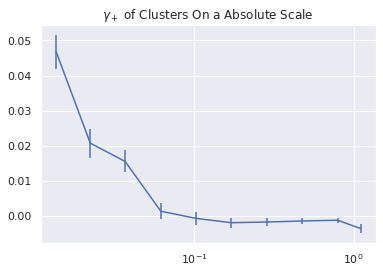

Aggregated xi:
[-76.536  -77.4594 -94.0256 -15.0434  13.8939  71.1905 114.5631 159.5293
 234.1465 332.0496]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -7038.2662 -14201.295  -19983.3133 -30858.8606 -46367.1783 -65698.593
 -83808.5115 -83150.7584 -44856.234    9339.9567]
------------------------------------------------------------------------------
Aggregated npairs:
[  1639.   3734.   6056.  11082.  20364.  37185.  66724. 111729. 193705.
  92804.]
------------------------------------------------------------------------------
Mean xi:
[-0.0467 -0.0207 -0.0155 -0.0014  0.0007  0.0019  0.0017  0.0014  0.0012
  0.0036]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2942 -3.8032 -3.2998 -2.7846 -2.2769 -1.7668 -1.256  -0.7442 -0.2316
  0.1006]
------------------------------------------------------------------------------


In [30]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

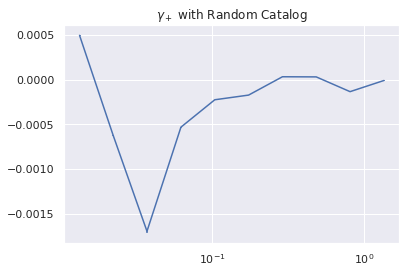

[ 4.9332e-04 -6.2438e-04 -1.6901e-03 -5.3002e-04 -2.2471e-04 -1.7261e-04
  3.1751e-05  3.0225e-05 -1.3427e-04 -1.0015e-05]
[-4.4173e-06  5.5909e-06  1.5134e-05  4.7459e-06  2.0121e-06  1.5456e-06
 -2.8431e-07 -2.7065e-07  1.2023e-06  8.9676e-08]


In [31]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

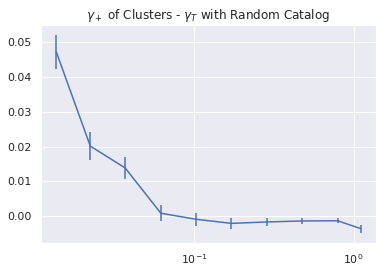

In [32]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

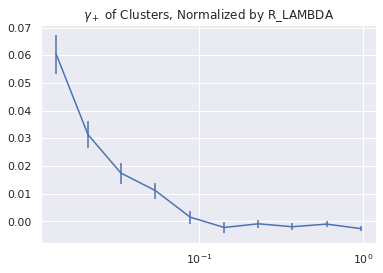

Aggregated xi:
[-43.5446 -72.3432 -71.8205 -76.4813 -18.8271  46.781   31.6499 123.8451
  99.7446 440.5145]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -3106.8702  -8906.2909 -13961.5439 -20036.2943 -29365.3725 -41751.3105
 -54990.1893 -64195.1305 -53512.9153  -6292.4499]
------------------------------------------------------------------------------
Aggregated npairs:
[   722.   2308.   4109.   6879.  12098.  21425.  37376.  64551. 103992.
 170686.]
------------------------------------------------------------------------------
Mean xi:
[-0.0603 -0.0313 -0.0175 -0.0111 -0.0016  0.0022  0.0008  0.0019  0.001
  0.0026]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3031 -3.8589 -3.3978 -2.9127 -2.4273 -1.9487 -1.4713 -0.9945 -0.5146
 -0.0369]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [33]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)